In [17]:
## LIST OF PACKAGES NEEDED
import csv
from pyirt import irt
import warnings
import logging
import numpy as np 
import pandas as pd 
import seaborn as sns
import scipy.stats as sp
from sklearn import mixture
import scipy.stats as stats
from kneed import KneeLocator
import scipy.special as special
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
import scipy.integrate as integrate
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix 

# Settings

- Plot settings: provides the color code used for figures
- List of functions: provides function to form dataframes; generate plots; compute statistics

In [18]:
## PLOT SETTINGS
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('pyirt').setLevel(logging.WARNING)
plt.rc('text', usetex=False) 
plt.rc('font', family='serif') 
fontsize_title = 21 
fontsize_axis = 17 
fontsize_ticks = 13
darkblue = "#2166ac"
lightblue = "#4393c3"
red = "#ff6961"
mediumblue = "cornflowerblue"
palered = "palevioletred"
green = "mediumseagreen"

In [19]:
## FUNCTIONS TO GET MLE FOR EQUAL OR QUANTILE CUT

# Compute the number of times where someone with Pi delegates to someone with Pj, stored in Z_MAT as a B*B matrix
# (B is the number of buckets)
def compute_z(df, expnum, code):
    d13 = df.loc[(df.ExpNum == expnum) & (df.CodeExclu == code)]
    sdf = d13.loc[d13.ProbaDel == 1]

    PI = d13.groupby('Buckets').count().ID.reset_index()
    PI_dict = dict(zip(list(PI.Buckets), list(PI.ID)))
    PI_dict = {k: v for k, v in PI_dict.items() if v > 0}

    s_PI = sdf.groupby('Buckets').count().ID.reset_index()
    s_PI_dict = dict(zip(list(s_PI.Buckets), list(s_PI.ID)))
    s_PI_dict = {k: v for k, v in s_PI_dict.items() if v > 0}

    v_exp_id, v_exp_del = [], []

    idn = [], []
    for i, r in d13.iterrows():
        if r.Weight == 0:
            v_exp_id.append(r.Buckets)
            del_exp = \
            list(d13.loc[(d13.ID == r.DelID) & (d13.CodeExclu == r.CodeExclu) & (d13.ExpNum == r.ExpNum)].Buckets)[0]
            v_exp_del.append(del_exp)
            idn.append(r.ID)
        if r.ID == r.GuruID and r.ProbaDel == 1 and len(d13.loc[d13.ID == r.DelID]):
            v_exp_id.append(r.Buckets)
            del_exp = \
            list(d13.loc[(d13.ID == r.DelID) & (d13.CodeExclu == r.CodeExclu) & (d13.ExpNum == r.ExpNum)].Buckets)[0]
            v_exp_del.append(del_exp)
            idn.append(r.ID)
    data_phi13 = pd.DataFrame(list(zip(v_exp_id, v_exp_del, idn)), columns=['I', 'J', 'Count'])
    Z = data_phi13.groupby(['I', 'J']).count().reset_index()
    B = sorted(list(set(list(d13.Buckets))))
    Z_MAT = []
    for pi in B:
        Z_j = []
        for pj in B:
            try:
                Z_j.append(list(Z.loc[(Z.I == pi) & (Z.J == pj)].Count)[0])
            except:
                Z_j.append(0)
        Z_MAT.append(Z_j)
    return Z_MAT, PI_dict, s_PI_dict


# Create the left-hand side of the system of linear equations
def computer_M(Z_MAT, map_bucket_to_index, i, PI_dict, B, e, c):
    M_I = []
    Mi = []
    pi_i = PI_dict[i]
    z_ii = Z_MAT[map_bucket_to_index[i]][map_bucket_to_index[i]]
    pi_i = sum(Z_MAT[map_bucket_to_index[i]])
    for l in B:
        if l == i:
            v = (PI_dict[i] - 1) * (z_ii - pi_i)
            Mi.append(v)
        else:
            v = z_ii * PI_dict[l]
            Mi.append(v)
    M_I.append(Mi)
    for j in B:
        if j != i:
            Mj = []
            z_ij = Z_MAT[map_bucket_to_index[i]][map_bucket_to_index[j]]
            pi_j = PI_dict[j]
            for l in B:
                if l == i:
                    v = z_ij * (PI_dict[i] - 1)
                    Mj.append(v)
                if l == j:
                    v = (z_ij - pi_i) * pi_j
                    Mj.append(v)
                if l not in [i, j]:
                    v = z_ij * PI_dict[l]
                    Mj.append(v)
            M_I.append(Mj)
    return M_I


def get_dataframe(df, i):
    df_phi_i = pd.DataFrame(columns=['pj', 'Weight', 'ExpNum', 'CodeExclu'])
    for e in list(set(df.ExpNum)):
        for c in list(set(df.CodeExclu)):
            Z_MAT, PI_dict, s_PI_dict = compute_z(df, e, c)
            map_ = {}
            ki = 0
            for k in list(PI_dict.keys()):
                map_[k] = ki
                ki += 1
            if i in s_PI_dict.keys() and PI_dict[i] > 1:
                M_I = computer_M(Z_MAT, map_, i, PI_dict, list(PI_dict.keys()), e, c)
                M_I[0] = [1 for i in range(len(M_I[-1]))]
                A = np.array(M_I)
                y = np.array([1] + [0] * (len(PI_dict) - 1))
                try:
                    x = np.linalg.solve(A, y)
                    ee_vec, cc_vec = [e] * len(x), [c] * len(x)
                    df_phi2 = pd.DataFrame(list(zip(list(PI_dict.keys()), x, ee_vec, cc_vec)),
                                           columns=['pj', 'Weight', 'ExpNum', 'CodeExclu'])
                    df_phi_i = df_phi_i.append(df_phi2, ignore_index=True)
                except:
                    print(e, c, i)
                    print(A)
                    print('Singular Matrix')
            if i in s_PI_dict.keys() and PI_dict[i] == 1:
                ee_vec, cc_vec = [e] * len(Z_MAT[map_[i]]), [c] * len(Z_MAT[map_[i]])
                df_phi2 = pd.DataFrame(list(zip(list(PI_dict.keys()), Z_MAT[map_[i]], ee_vec, cc_vec)),
                                       columns=['pj', 'Weight', 'ExpNum', 'CodeExclu'])
                df_phi_i = df_phi_i.append(df_phi2, ignore_index=True)
    return df_phi_i

## FUNCTIONS TO GET MLE FOR GMM OR k-MEANS

# Compute the number of times where someone with Pi delegates to someone with Pj, stored in Z_MAT as a B*B matrix
# (B is the number of Labels_GMM)
def compute_z_gmm(df, expnum, code):
    d13 = df.loc[(df.ExpNum == expnum) & (df.CodeExclu == code)]
    sdf = d13.loc[d13.ProbaDel == 1]

    PI = d13.groupby('Labels_GMM').count().ID.reset_index()
    PI_dict = dict(zip(list(PI.Labels_GMM), list(PI.ID)))
    PI_dict = {k: v for k, v in PI_dict.items() if v > 0}

    s_PI = sdf.groupby('Labels_GMM').count().ID.reset_index()
    s_PI_dict = dict(zip(list(s_PI.Labels_GMM), list(s_PI.ID)))
    s_PI_dict = {k: v for k, v in s_PI_dict.items() if v > 0}

    v_exp_id, v_exp_del = [], []

    idn = []
    for i, r in d13.iterrows():
        if r.Weight == 0:
            v_exp_id.append(r.Labels_GMM)
            del_exp = \
            list(d13.loc[(d13.ID == r.DelID) & (d13.CodeExclu == r.CodeExclu) & (d13.ExpNum == r.ExpNum)].Labels_GMM)[0]
            v_exp_del.append(del_exp)
            idn.append(r.ID)
        if r.ID == r.GuruID and r.ProbaDel == 1 and len(d13.loc[d13.ID == r.DelID]):
            v_exp_id.append(r.Labels_GMM)
            del_exp = \
            list(d13.loc[(d13.ID == r.DelID) & (d13.CodeExclu == r.CodeExclu) & (d13.ExpNum == r.ExpNum)].Labels_GMM)[0]
            v_exp_del.append(del_exp)
            idn.append(r.ID)

    data_phi13 = pd.DataFrame(list(zip(v_exp_id, v_exp_del, idn)), columns=['I', 'J', 'Count'])

    Z = data_phi13.groupby(['I', 'J']).count().reset_index()
    B = sorted(list(set(list(d13.Labels_GMM))))
    Z_MAT = []
    for pi in B:
        Z_j = []
        for pj in B:
            try:
                Z_j.append(list(Z.loc[(Z.I == pi) & (Z.J == pj)].Count)[0])
            except:
                Z_j.append(0)
        Z_MAT.append(Z_j)
    return Z_MAT, PI_dict, s_PI_dict


# Create the left-hand side of the system of linear equations
def computer_M_gmm(Z_MAT, map_bucket_to_index, i, PI_dict, B, e, c):
    M_I = []
    Mi = []
    pi_i = PI_dict[i]
    z_ii = Z_MAT[map_bucket_to_index[i]][map_bucket_to_index[i]]
    pi_i = sum(Z_MAT[map_bucket_to_index[i]])
    for l in B:
        if l == i:
            v = (PI_dict[i] - 1) * (z_ii - pi_i)
            Mi.append(v)
        else:
            v = z_ii * PI_dict[l]
            Mi.append(v)
    M_I.append(Mi)
    for j in B:
        if j != i:
            Mj = []
            z_ij = Z_MAT[map_bucket_to_index[i]][map_bucket_to_index[j]]
            pi_j = PI_dict[j]
            for l in B:
                if l == i:
                    v = z_ij * (PI_dict[i] - 1)
                    Mj.append(v)
                if l == j:
                    v = (z_ij - pi_i) * pi_j
                    Mj.append(v)
                if l not in [i, j]:
                    v = z_ij * PI_dict[l]
                    Mj.append(v)
            M_I.append(Mj)
    return M_I


def get_dataframe_gmm(df, i):
    df_phi_i = pd.DataFrame(columns=['pj', 'Weight', 'ExpNum', 'CodeExclu'])
    for e in list(set(df.ExpNum)):
        for c in list(set(df.CodeExclu)):
            Z_MAT, PI_dict, s_PI_dict = compute_z_gmm(df, e, c)
            map_ = {}
            ki = 0
            for k in list(PI_dict.keys()):
                map_[k] = ki
                ki += 1
            if i in s_PI_dict.keys() and PI_dict[i] > 1:
                M_I = computer_M_gmm(Z_MAT, map_, i, PI_dict, list(PI_dict.keys()), e, c)
                M_I[0] = [1 for i in range(len(M_I[-1]))]
                A = np.array(M_I)
                y = np.array([1] + [0] * (len(PI_dict) - 1))
                try:
                    x = np.linalg.solve(A, y)
                    ee_vec, cc_vec = [e] * len(x), [c] * len(x)
                    df_phi2 = pd.DataFrame(list(zip(list(PI_dict.keys()), x, ee_vec, cc_vec)),
                                           columns=['pj', 'Weight', 'ExpNum', 'CodeExclu'])
                    df_phi_i = df_phi_i.append(df_phi2, ignore_index=True)
                except:
                    print(e, c, i)
                    print(A)
                    print('Singular Matrix')
            if i in s_PI_dict.keys() and PI_dict[i] == 1:
                ee_vec, cc_vec = [e] * len(Z_MAT[map_[i]]), [c] * len(Z_MAT[map_[i]])
                df_phi2 = pd.DataFrame(list(zip(list(PI_dict.keys()), Z_MAT[map_[i]], ee_vec, cc_vec)),
                                       columns=['pj', 'Weight', 'ExpNum', 'CodeExclu'])
                df_phi_i = df_phi_i.append(df_phi2, ignore_index=True)
    return df_phi_i

# Data Processing
- This section processes the data

In [20]:
## OPEN DATA AND SET SLICE

df = pd.read_csv('../data/data.csv')
dict_labels = {'TT':'Q1','K':'Q2', 'KK':'Q3', 'T':'Q4', 'PE13':'Q5', 'S':'Q6', 'KKK':'Q7', 'PC':'Q8', 'PCPC':'Q9', 'TTT':'Q10', 'PE8':'Q11', 'PE9':'Q12', 'PPE13':'Q13', 'KKKK':'Q14', 'PE12':'Q15', 'PPPE13':'Q16'}
focus_on = 'B2' #"B2" for main study, "B1" for pre-study

In [21]:
## HIGH LEVEL STATISTICS ON AVERAGE PERFORMANCE
if focus_on == 'B1':
    exp_filter = df.loc[df.ExpNum.isin(['E1','E2','E3','E4','E5','E6'])]
else:
    exp_filter = df.loc[df.ExpNum.isin(['E8','E9','E10','E11','E12','E13'])]

In [22]:
## CREATE AGGREGATED DATAFRAMES
# behavior: groups data by USER ID (ID+ExpNum) 
# behavior_agg: groups data by USER ID (ID+ExpNum) and by TASK (CodeExclu)

dct= {
    'number': 'mean',
    'object': lambda col: col.mode() if col.nunique() == 1 else np.nan,
}
dct_interm = {k: v for i in [{col: agg for col in exp_filter.select_dtypes(tp).columns.difference(['ExpNum', 'ID'])} for tp, agg in dct.items()] for k, v in i.items()}
behavior_agg = exp_filter.groupby(['ExpNum', 'ID']).agg(**{k: (k, v) for k, v in dct_interm.items()}).reset_index()
dct_interm = {k: v for i in [{col: agg for col in exp_filter.select_dtypes(tp).columns.difference(['ExpNum', 'ID', 'CodeExclu'])} for tp, agg in dct.items()] for k, v in i.items()}
behavior = exp_filter.groupby(['ExpNum', 'ID', 'CodeExclu']).agg(**{k: (k, v) for k, v in dct_interm.items()}).reset_index()

# High-level Statistics

- Average accuracy of LD and DD overall and per experiment
- Number of participant per experiment

In [23]:
## HIGH LEVEL STATISTICS ON AVERAGE PERFORMANCE
print(f'Average LD increase over DD: {- np.mean(df.Answer) + np.mean(df.Answer*df.Weight)}')
print(f'Average LD increase over DD in {focus_on}: {- np.mean(exp_filter.Answer) + np.mean(exp_filter.Answer*exp_filter.Weight)}')
print('---')
if focus_on == 'B1':
    for k in ['E1','E2','E3','E4','E5','E6']:
        exp_filter_ = exp_filter.loc[exp_filter.ExpNum==k]
        print(np.mean(exp_filter_.Answer), np.mean(exp_filter_.Answer*exp_filter_.Weight))
else:
    for k in ['E8','E9','E10','E11','E12','E13']:
        exp_filter_ = exp_filter.loc[exp_filter.ExpNum==k]
        print(f'In experiment: {k} \n DD accuracy: {np.mean(exp_filter_.Answer)} \n LD accuracy: {np.mean(exp_filter_.Answer*exp_filter_.Weight)}')  
        print('---')

Average LD increase over DD: 0.03677384970687514
Average LD increase over DD in B2: 0.041970802919708006
---
In experiment: E8 
 DD accuracy: 0.6138392857142857 
 LD accuracy: 0.625
---
In experiment: E9 
 DD accuracy: 0.6747159090909091 
 LD accuracy: 0.703125
---
In experiment: E10 
 DD accuracy: 0.631578947368421 
 LD accuracy: 0.6644736842105263
---
In experiment: E11 
 DD accuracy: 0.6287878787878788 
 LD accuracy: 0.6609848484848485
---
In experiment: E12 
 DD accuracy: 0.7022569444444444 
 LD accuracy: 0.7430555555555556
---
In experiment: E13 
 DD accuracy: 0.5729166666666666 
 LD accuracy: 0.6233333333333333
---


In [24]:
## TABLE 3

if focus_on == 'B1':
    exp_ = ['E1','E2','E3','E4','E5','E6']
else:
    exp_ = ["E8", "E9", "E10", "E11", "E12", "E13"]
    
tot = 0
for k in exp_:
    print("Number of participants in ", k, " ", str(len(list(set(df.loc[df.ExpNum == k].ID)))))
    tot += len(list(set(df.loc[df.ExpNum == k].ID)))
print("Number of total participants: ", tot)

Number of participants in  E8   14
Number of participants in  E9   22
Number of participants in  E10   19
Number of participants in  E11   27
Number of participants in  E12   36
Number of participants in  E13   50
Number of total participants:  168


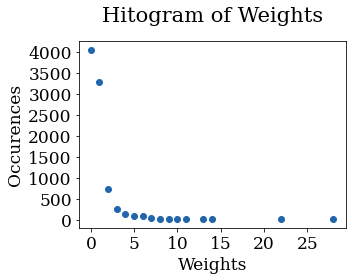

In [25]:
## (EXPLORATORY) HISTOGRAM OF DELEGATION WEIGHT

w = list(exp_filter.groupby('Weight').count().index)
c = list(exp_filter.groupby('Weight').count().ID) 
plt.figure(figsize=(5, 4))
plt.xticks(rotation=0, fontsize=fontsize_axis, label='Weight') 
plt.yticks(rotation=0, fontsize=fontsize_axis, label='Occurences') 
plt.title('Hitogram of Weights', fontsize=fontsize_title, pad=20) 
plt.tick_params(which='minor', bottom=False)
plt.xlabel('Weights', fontsize=fontsize_axis)
plt.ylabel('Occurences', fontsize=fontsize_axis)
plt.scatter(w, c, color=darkblue)
plt.tight_layout()

/Users/Manon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.
/Users/Manon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  


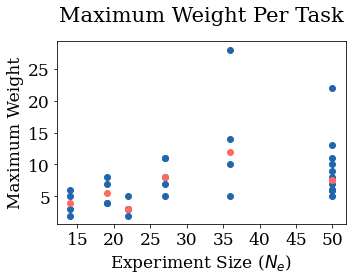

In [26]:
## (EXPLORATORY) MAX WEIGHT RECEIVED AS A FUNCTION OF THE EXPERIMENT SIZE

if focus_on == 'B1':
    dict_size = {"E1": 11, "E2": 12, "E3": 32, "E4": 14, "E5": 17, "E6": 15}
else:
    dict_size = {"E8": 14, "E9": 22, "E10": 19, "E11": 27, "E12": 36, "E13": 50}
size, max_w = [], []
avgsize, avgmax_w = [], []
for name, group in exp_filter.groupby('ExpNum'):
    for k in list(group.groupby('CodeExclu').max().Weight): 
        size.append(dict_size[name])
        max_w.append(k)
    avgsize.append(dict_size[name])
    avgmax_w.append(np.median(list(group.groupby('CodeExclu').max().Weight)))

plt.figure(figsize=(5, 4))
plt.xticks(rotation=0, fontsize=fontsize_axis, label='N') 
plt.yticks(rotation=0, fontsize=fontsize_axis, label='Max Weight') 
plt.title('Maximum Weight Per Task', fontsize=fontsize_title, pad=20) 
plt.tick_params(which='minor', bottom=False)
plt.xlabel('Experiment Size ($N_e$)', fontsize=fontsize_axis)
plt.ylabel('Maximum Weight', fontsize=fontsize_axis)
plt.scatter(size, max_w, color=darkblue)
plt.scatter(avgsize, avgmax_w, color=red)
plt.tight_layout()

/Users/Manon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


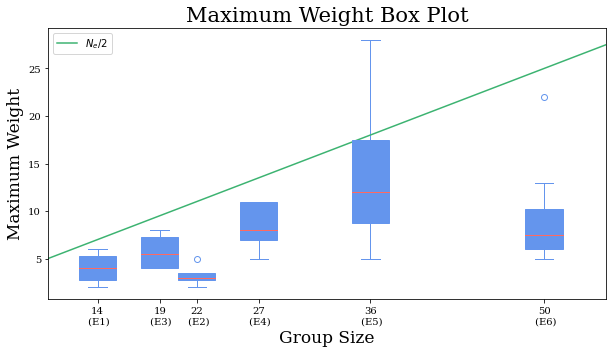

In [27]:
## [FIGURE 18]

data = []
e = []
e_label = []
for name, group in exp_filter.groupby('ExpNum'):
    e.append(dict_size[name])
    e_label.append(str(dict_size[name]) + "\n (E" + str(int(name.split('E')[1])-7) + ")") 
    max_w = []
    for k in list(group.groupby('CodeExclu').max().Weight):
            max_w.append(k)
    data.append(max_w)

medians = [np.median(d) for d in data]

e, data, e_label = zip(*sorted(zip(e, data, e_label), key=lambda x: np.median(x[0])))
c = mediumblue

if focus_on == 'B1':
    fig, ax = plt.subplots(figsize=(10, 5)) 
    ax.boxplot(data, notch=False, patch_artist=True,
                    boxprops=dict(facecolor=c, color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c), medianprops=dict(color=red), positions=e, widths=0.5)
    ax.set_xlabel('Group Size', fontsize=fontsize_axis)
    ax.set_ylabel('Maximum Weight', fontsize=fontsize_axis)
    ax.set_title('Maximum Weight Box Plot', fontsize=fontsize_title)
    ax.set_xticklabels(e_label)
    ax.set_xlim([9, 35])
    ax.plot([9, 35], [9/2, 35/2], color = green, label = '$N_e/2$')
    ax.legend()
    plt.savefig('../figures/Figure18_pre.pdf')
else:
    fig, ax = plt.subplots(figsize=(10, 5)) 
    ax.boxplot(data, notch=False, patch_artist=True,
                    boxprops=dict(facecolor=c, color=c),
                    capprops=dict(color=c),
                    whiskerprops=dict(color=c),
                    flierprops=dict(color=c, markeredgecolor=c), medianprops=dict(color=red), positions=e, widths=3)
    ax.set_xlabel('Group Size', fontsize=fontsize_axis)
    ax.set_ylabel('Maximum Weight', fontsize=fontsize_axis)
    ax.set_title('Maximum Weight Box Plot', fontsize=fontsize_title)
    ax.set_xticklabels(e_label)
    ax.set_xlim([10, 55])
    ax.plot([10, 55], [10/2, 55/2], color = green, label = '$N_e/2$')
    ax.legend()
    plt.savefig('../figures/Figure18.pdf')

# Compute Expertise
- This section computes the expertise accounting for individual and questions heterogeneity, discusses the bucketing strategies and how to compute $\varphi$

In [28]:
exp_filter['unique_id'] = exp_filter['ExpNum'] + '_' + exp_filter['ID'].astype(str)
exp_filter['unique_id_q'] = exp_filter['ExpNum'] + '_' + exp_filter['ID'].astype(str) + '_' + exp_filter['CodeExclu']
expertise = exp_filter.groupby(['ID', 'ExpNum', 'CodeExclu', "unique_id", "unique_id_q"]).mean().AverageExpertise.reset_index()

questions_score = {}
expertise['IRTExpertise'] =  pd.Series([0] * len(expertise))

for name, group in exp_filter.groupby(["CodeExclu"]):
    l = list(group[["unique_id_q", "CodeQuestion", "Answer"]].itertuples(index=False, name=None))
    item_param, user_param = irt(l)
    questions_score.update(item_param)
    update_b = lambda x: user_param[x['unique_id_q']] if x['unique_id_q'] in user_param else x['IRTExpertise']
    expertise['IRTExpertise'] = expertise.apply(update_b, axis=1)
    
expertise["Normalized_IRT"]  = expertise["IRTExpertise"].subtract(min(expertise["IRTExpertise"])).divide(max(expertise["IRTExpertise"])-min(expertise["IRTExpertise"]))
expertise["Normalized_IRT_1"]  = expertise["IRTExpertise"].subtract(min(expertise["IRTExpertise"])).divide((max(expertise["IRTExpertise"])-min(expertise["IRTExpertise"]))/20).subtract(10)

np.corrcoef(expertise.AverageExpertise, expertise.Normalized_IRT), np.corrcoef(expertise.AverageExpertise, expertise.Normalized_IRT_1)

/Users/Manon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Manon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
2024-11-15 19:07:15 INFO: start loading data
start loading data
start loading data
start loading data
start loading data
start loading data
start loading data
start loading data
start loading data
start loading 

(array([[1.        , 0.94956723],
        [0.94956723, 1.        ]]),
 array([[1.        , 0.94956723],
        [0.94956723, 1.        ]]))

# Delegation and Expertise Plots

- This section provides code to generate the figures about delegation metrics

In [29]:
merged_df = pd.merge(behavior, expertise, left_on=['ExpNum', 'ID', 'CodeExclu'], right_on=['ExpNum', 'ID', 'CodeExclu'], how='left')
merged_df_flat = pd.merge(exp_filter, expertise[['IRTExpertise', 'Normalized_IRT', 'Normalized_IRT_1', 'unique_id_q']], on=["unique_id_q"], how='left')
merged_df = merged_df.loc[~(merged_df.CodeExclu == 'S')]

if focus_on == 'B2': 
    merged_df.to_csv('../data/R_paper.csv') 
else:
    merged_df.to_csv('../data/R_paper_pre_study.csv') 

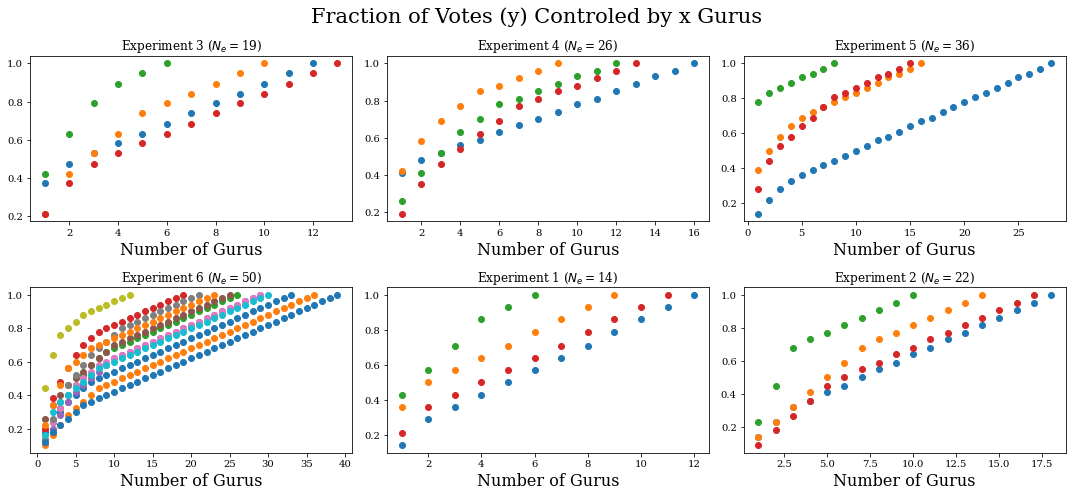

In [30]:
## [FIGURE 19]

fig, axes = plt.subplots(2,3, figsize=(15,7))
gg_, i_, mini_ = [], [], []
e, e_label = [], []
data = []
dict_all = {}
aks = 0
for name, group in merged_df.groupby(['ExpNum']):
    ax = axes.flatten()[aks]
    ma = []
    for n, gg in group.groupby('CodeExclu'):
        di = {}
        g = gg.loc[gg.Weight!=0]
        l = sorted(g.Weight, reverse = True) 
        s=0
        i=1
        mini = 100
        for k in l:
            s += k
            dict_all[round(i,2)] = round(s/len(gg), 2) 
            di[i] = round(s/len(gg), 2)
            if s/len(gg) > 0.5:
                mini = min(mini,i)
            i += 1
        gg_.append(len(gg))
        i_.append(i)
        mini_.append(mini)
        ma.append(mini)
        ax.scatter(list(di.keys()),list(di.values()))
    data.append(ma)
    e.append(len(gg))
    e_label.append(str(len(gg)) + "\n (E" + str(int(name.split('E')[1])-7) + ")") 
    ax.set_xlabel("Number of Gurus", fontsize=16)
    ax.set_title("Experiment " + str(int(name.split('E')[1])-7) + ' ($N_e=$' + str(len(gg)) + ")")
    aks += 1

plt.suptitle('Fraction of Votes (y) Controled by x Gurus', fontsize=fontsize_title)
plt.tight_layout()
plt.savefig('../figures/Figure19.pdf')

2024-11-15 19:08:23 WARNING: No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to

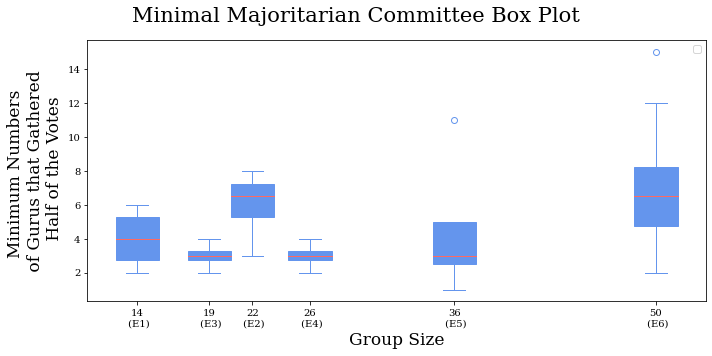

In [31]:
## [FIGURE 20]

medians = [np.median(d) for d in data]

e, data, e_label = zip(*sorted(zip(e, data, e_label), key=lambda x: np.median(x[0])))
c = mediumblue

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(data, notch=False, patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c), medianprops=dict(color=red), positions=e, widths=3)
ax.set_xlabel('Group Size', fontsize=fontsize_axis)
ax.set_ylabel('Minimum Numbers \n of Gurus that Gathered \n Half of the Votes', fontsize=fontsize_axis)
ax.set_xticklabels(e_label)
ax.legend()
plt.suptitle('Minimal Majoritarian Committee Box Plot', fontsize=fontsize_title)
plt.tight_layout()
plt.savefig('../figures/Figure20.pdf')

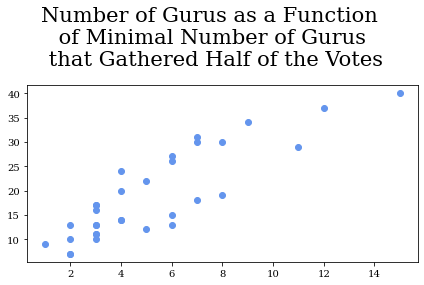

In [32]:
## [FIGURE 21]

plt.scatter(mini_, i_, color = mediumblue)
plt.suptitle('Number of Gurus as a Function \n of Minimal Number of Gurus \n that Gathered Half of the Votes', fontsize=fontsize_title)
plt.tight_layout()
plt.savefig('../figures/Figure21.pdf')

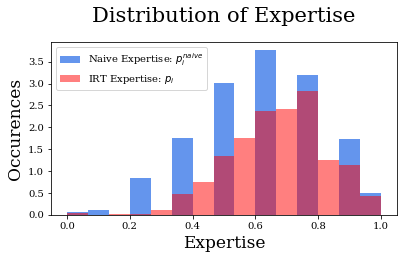

In [33]:
## [FIGURE 22]

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
behavior.AverageExpertise.hist(color=mediumblue, label='Naive Expertise: $p^{naive}_i$', bins=15, density = True) 
expertise.Normalized_IRT.hist(color='red', label='IRT Expertise: $p_i$', bins=15, alpha=0.5, density = True)
ax.set_title('Distribution of Expertise', fontsize=fontsize_title, pad=20) 
ax.tick_params(which='minor', axis='x', labelsize=fontsize_axis, bottom=False) 
ax.tick_params(which='minor', axis='y', labelsize=fontsize_axis, bottom=False) 
ax.set_xlabel('Expertise', fontsize=fontsize_axis)
ax.set_ylabel('Occurences', fontsize=fontsize_axis) 
ax.legend()
ax.grid(False)
fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.9)
if focus_on == 'B1': 
    plt.savefig('../figures/Figure22.pdf',bbox_inches='tight')
else: 
    plt.savefig('../figures/expertiseB2.pdf',bbox_inches='tight')

In [34]:
## PREPARE DATA FOR ANOVA ANALYSIS

if focus_on == 'B2': 
    merged_df.groupby('ID').mean()
    dct = {
        'number': 'mean',
        'object': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    }
    groupby_cols = ['unique_id']
    dct = {k: v for i in [{col: agg for col in merged_df.select_dtypes(tp).columns.difference(groupby_cols)} for tp, agg in dct.items()] for k, v in i.items()}
    anova = merged_df.groupby(groupby_cols).agg(**{k: (k, v) for k, v in dct.items()}).reset_index() 
    anova[anova['gender'].notna()].to_csv('../data/anova.csv')
    anova.to_csv('../data/anova.csv')

# Estimating $q$ and $\varphi$

## Bucketing

- This section provides the code to generate various bucketing strategies
  - Gaussian Mixture
  - K-mean clustering
  - Equal cut 
  - Quantile cut


### Gaussian Mixture 

In [38]:
X = np.array(list(merged_df.Normalized_IRT)).reshape(-1, 1) 
n_components_range = range(1, 11) 

# Function to calculate the log likelihood of the GMM model on the data
def log_likelihood(estimator, X):
    return np.sum(estimator.score_samples(X))

cv_scores = []  # List to store cross-validation scores for each number of components
for n_components in n_components_range:
    gmm = mixture.GaussianMixture(n_components=n_components,n_init=100,max_iter=50000, covariance_type='full', init_params='random')
    scores = cross_val_score(gmm, X, cv=5, scoring=log_likelihood)
    cv_scores.append(np.mean(scores))

# Find the optimal number of components by selecting the one with the highest log likelihood
optimal_n_components = n_components_range[np.argmax(cv_scores)]
# Fit the final GMM with the optimal number of components
final_gmm = mixture.GaussianMixture(n_components=optimal_n_components)
final_gmm.fit(X)
final_score = final_gmm.score(X)

print("Optimal number of components:", optimal_n_components)
print("Final GMM score:", final_score)

# Map the predicted labels to the new labels
class_means = final_gmm.means_.flatten()
sorted_indices = np.argsort(class_means)
new_labels = {old_label: new_label for old_label, new_label in enumerate(sorted_indices)}
gmm_labels = final_gmm.predict(np.array(list(merged_df.Normalized_IRT)).reshape(-1, 1)) 
new_gmm_labels = [new_labels[label] for label in gmm_labels]

class_means = final_gmm.means_.flatten() 
dict_m = {}
for k in range (len(class_means)):
    dict_m[k] = class_means[k]

    merged_df["Labels_GMM"] = final_gmm.predict(np.array(list(merged_df.Normalized_IRT)).reshape(-1, 1))
merged_df["Labels_GMM"] = merged_df["Labels_GMM"].map(dict_m)
merged_df.groupby('Labels_GMM').count().Normalized_IRT.divide(sum(merged_df.groupby('Labels_GMM').count().Normalized_IRT)/100)


Optimal number of components: 5
Final GMM score: 0.476491542820525


Labels_GMM
0.460347     6.915888
0.541028    23.364486
0.668980    32.616822
0.780808    20.934579
0.873097    16.168224
Name: Normalized_IRT, dtype: float64

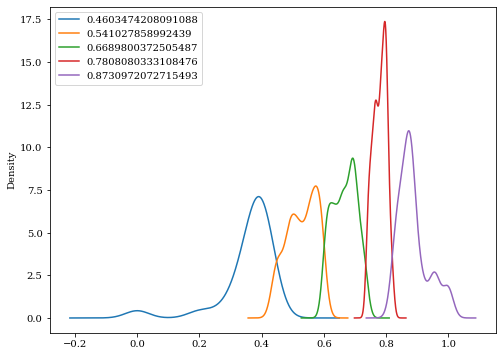

In [39]:
## (EXPLORATORY) 

fig, ax = plt.subplots(figsize=(8,6))
for label, df in merged_df.groupby('Labels_GMM'):
    df.Normalized_IRT.plot(kind="kde", ax=ax, label=label)
plt.legend()

### K-means clustering

In [40]:
## TABLE 1

def find_closest(x):
    return min(l, key=lambda y: abs(y - x)**2)

kmeans_kwargs = {"init": "k-means++","n_init": 10,"max_iter": 10000,"random_state": 42,}
sse = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
kl = KneeLocator(range(1, 25), sse, curve="convex", direction="decreasing")
print(kl.elbow)

kmeans = KMeans(init="k-means++", n_clusters=kl.elbow,n_init=10, max_iter=300, random_state=42) 
kmeans.fit(X)
l = kmeans.cluster_centers_
l = [k[0] for k in l]

merged_df['v_Labels_GMM'] = merged_df['Normalized_IRT'].apply(find_closest)
merged_df.groupby('v_Labels_GMM').count().Normalized_IRT.divide(sum(merged_df.groupby('v_Labels_GMM').count().Normalized_IRT)/100)


4


v_Labels_GMM
0.426732    16.074766
0.603843    31.962617
0.746207    35.046729
0.883915    16.915888
Name: Normalized_IRT, dtype: float64

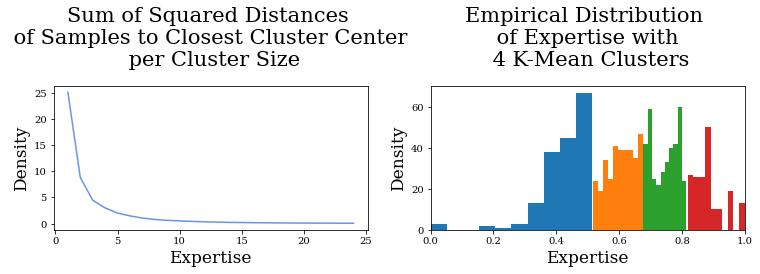

In [41]:
## (EXPLORATORY) K-MEAN CLUSTERING

fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(321)
ax.plot(range(1, 25), sse, color=c)
ax.set_title('Sum of Squared Distances \n of Samples to Closest Cluster Center \n per Cluster Size', fontsize=fontsize_title, pad=20)
ax.tick_params(which='minor', axis='x', labelsize=fontsize_axis, bottom=False)
ax.tick_params(which='minor', axis='y', labelsize=fontsize_axis, bottom=False)
ax.set_xlabel('Expertise', fontsize=fontsize_axis)
ax.set_ylabel('Density', fontsize=fontsize_axis)

ax = fig.add_subplot(322)
for label, df in merged_df.groupby('v_Labels_GMM'):
    df.Normalized_IRT.plot(kind="hist", ax=ax, label=label)
ax.set_title('Empirical Distribution \n of Expertise with \n 4 K-Mean Clusters', fontsize=fontsize_title, pad=20) 
ax.tick_params(which='minor', axis='x', labelsize=fontsize_axis, bottom=False)
ax.tick_params(which='minor', axis='y', labelsize=fontsize_axis, bottom=False)
ax.set_xlabel('Expertise', fontsize=fontsize_axis)
ax.set_ylabel('Density', fontsize=fontsize_axis)
ax.set_xlim(0, 1)

fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.9)

### Equal Cut

In [42]:
buckets_num = 4
delta = (max(merged_df.Normalized_IRT) - min(merged_df.Normalized_IRT))/buckets_num
cut_offs = [delta*i for i in range(buckets_num + 1)]
labels = [round((cut_offs[i]+cut_offs[i+1])/2,2) for i in range (buckets_num)]
merged_df['Buckets'] = pd.cut(merged_df.Normalized_IRT, bins = cut_offs, labels=labels, include_lowest=True)

labels = {}
for n, g in merged_df.groupby('Buckets'):
    labels[n] = np.mean(g.Normalized_IRT)

merged_df['Buckets'] = merged_df['Buckets'].map(labels)
merged_df.groupby('Buckets').count().Normalized_IRT.divide(sum(merged_df.groupby('Buckets').count().Normalized_IRT)/100)


Buckets
0.10121510763595205     0.560748
0.4305186919747956     13.925234
0.6366300732192194     50.934579
0.8324600598511738     34.579439
Name: Normalized_IRT, dtype: float64

### Quantile Cut

In [43]:
merged_df['Buckets'] = pd.qcut(merged_df.Normalized_IRT, buckets_num) 
labels = []
for n, g in merged_df.groupby('Buckets'):
    labels.append(np.median(g.Normalized_IRT))

merged_df['q_Buckets'] = pd.qcut(merged_df.Normalized_IRT, buckets_num, labels =labels)
merged_df.groupby('q_Buckets').count().Normalized_IRT.divide(sum(merged_df.groupby('q_Buckets').count().Normalized_IRT)/100)

q_Buckets
0.4907051720276372    25.140187
0.6349560721366321    25.794393
0.7395854103218806    24.018692
0.851481283001594     25.046729
Name: Normalized_IRT, dtype: float64

## Compute Phi

- This section provides the code to compute the maximum likelihood estimator for $\varphi$ for various bucketing methods

In [44]:
method = 'k_gmm' #'buckets', "gmm", 'q_buckets', 'k_gmm'

In [45]:
if method in ['buckets', 'q_buckets']:
    if method == 'q_buckets':
        merged_df['Buckets'] = merged_df['q_Buckets']
    B = sorted(list(set(list(merged_df.Buckets))))
    df_phi_tot = pd.DataFrame(columns=['pj', 'Weight'])
    kf = 0
    d_weights_total = pd.DataFrame(columns=['pj', 'Weight', 'ExpNum', 'CodeExclu', 'pi']) 
    for i in B:
        df_phi_i = get_dataframe(merged_df[['ID', 'DelID', 'CodeExclu', 'ExpNum', 'Buckets', 'Weight', 'ProbaDel', 'GuruID']], i)
        df_phi_i["pi"] = [i]*len(df_phi_i)
        d_weights_total = d_weights_total.append(df_phi_i, ignore_index=True)        
        new_d = df_phi_i.groupby('pj').mean().reset_index()
        dd_i = pd.DataFrame(list(zip(list(df_phi_i.pj), list(df_phi_i.Weight))), columns=['pj', 'Weight']) 
        df_phi_tot = df_phi_tot.append(dd_i, ignore_index=True)

if method in ['gmm', 'k_gmm']:
    if method == 'k_gmm':
        merged_df['Labels_GMM'] = merged_df['v_Labels_GMM']
    B = sorted(list(set(list(merged_df.Labels_GMM))))
    df_phi_tot = pd.DataFrame(columns=['pj', 'Weight'])
    kf = 0
    d_weights_total = pd.DataFrame(columns=['pj', 'Weight', 'ExpNum', 'CodeExclu', 'pi']) 
    for i in B:
        df_phi_i = get_dataframe_gmm(merged_df[['ID', 'DelID', 'CodeExclu', 'ExpNum', 'Labels_GMM', 'Weight', 'ProbaDel', 'GuruID']], i)
        df_phi_i["pi"] = [i]*len(df_phi_i)
        d_weights_total = d_weights_total.append(df_phi_i, ignore_index=True)
        new_d = df_phi_i.groupby('pj').mean().reset_index()
        dd_i = pd.DataFrame(list(zip(list(df_phi_i.pj), list(df_phi_i.Weight))), columns=['pj', 'Weight']) 
        df_phi_tot = df_phi_tot.append(dd_i, ignore_index=True)

In [46]:
## [TABLE 2] with method = "k_gmm"

# --- Also
## [TABLE 9] with method = "buckets" and bucket_num = 3
## [TABLE 10] with method = "buckets" and bucket_num = 5
## [TABLE 11] with method = "buckets" and bucket_num = 7
## [TABLE 12] with method = "buckets" and bucket_num = 10
## [TABLE 13] with method = "q_buckets" and bucket_num = 10


res = stats.kendalltau(d_weights_total.Weight, d_weights_total.pj)
print(res)
for name, group in d_weights_total.groupby('pi'): 
    print(stats.kendalltau(group.Weight, group.pj))

KendalltauResult(correlation=0.17002495490971528, pvalue=2.673077450695741e-05)
KendalltauResult(correlation=0.19587795411871062, pvalue=0.024130365525409772)
KendalltauResult(correlation=0.1238683131390592, pvalue=0.0990088101469531)
KendalltauResult(correlation=0.11129681527556623, pvalue=0.1375303909764839)
KendalltauResult(correlation=0.2769616378470065, pvalue=0.0033127129157391783)


In [47]:
## [TABLE 8]

res = stats.kendalltau(d_weights_total.Weight, d_weights_total.pj)
for name, group in d_weights_total.groupby(['CodeExclu']):
    print(name)
    print(stats.kendalltau(group.Weight, group.pj))

K
KendalltauResult(correlation=0.36474450320616936, pvalue=0.0010654861993410042)
KK
KendalltauResult(correlation=-0.19245008972987526, pvalue=0.5392389659645473)
KKK
KendalltauResult(correlation=-0.5231388366621641, pvalue=0.012741329975105244)
KKKK
KendalltauResult(correlation=-0.24900596027799873, pvalue=0.22997098364621482)
PC
KendalltauResult(correlation=0.2620972544812905, pvalue=0.00786034095151336)
PCPC
KendalltauResult(correlation=0.5644117345171042, pvalue=0.00592383175592837)
PE12
KendalltauResult(correlation=-0.13715853329963723, pvalue=0.5666093397561894)
PE13
KendalltauResult(correlation=0.5767706416667591, pvalue=0.005079631966722956)
PE8
KendalltauResult(correlation=-0.1539600717839002, pvalue=0.6233052377085786)
PE9
KendalltauResult(correlation=-0.20546489665077206, pvalue=0.10044422555145206)
PPE13
KendalltauResult(correlation=0.47683060329893284, pvalue=0.020075251975266977)
PPPE13
KendalltauResult(correlation=-0.2689264371002386, pvalue=0.19481419629674246)
T
Kendal

1.074829838012606
1.08573364457677
1.0761533733877193
1.022408963585434


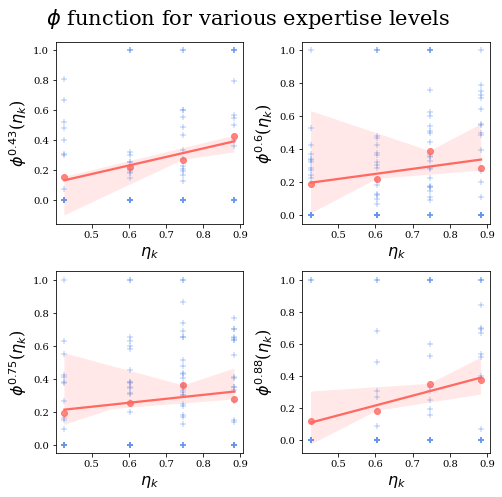

In [48]:
## [FIGURE 2 (a)] with method = "k_gmm"

# --- Also
## [FIGURE 12 (a)] with method = "buckets" and bucket_num = 3
## [FIGURE 13 (a)] with method = "buckets" and bucket_num = 5
## [FIGURE 14 (a)] with method = "buckets" and bucket_num = 7
## [FIGURE 15 (a)] with method = "buckets" and bucket_num = 10
## [FIGURE 16 (a)] with method = "q_buckets" and bucket_num = 10
## [FIGURE 24 (a)] with method = "k_gmm" and focus_on = "B1"

fig, axes = plt.subplots(2, 2, figsize=(7,7)) # Note that you may need to adjust the subplots numbers depending on the number of buckets you are considering

for i, prog in enumerate(B[:buckets_num+1]):
    filter_ = d_weights_total.loc[d_weights_total.pi == prog]
    new_d = filter_.groupby('pj').agg({'Weight': 'mean'}).reset_index()
    ax = axes.flatten()[i]
    ax.grid(False)
    sns.scatterplot(x='pj', y='Weight', data=filter_, color=mediumblue, ax=ax, marker='+') 
    sns.regplot(x='pj', y='Weight', data=new_d, scatter=True, color=red, ax=ax) 
    ax.set_xlabel('$\eta_k$', fontsize=16) 
    ax.set_ylabel('$\phi^{'+str(round(prog,2))+'}$($\eta_k$)', fontsize=16) 
    print(sum(new_d.Weight))

plt.suptitle('$\phi$ function for various expertise levels', fontsize=fontsize_title)
plt.tight_layout()

if focus_on == 'B1': 
    plt.savefig('../figures/Figure24a.pdf')
else: 
    plt.savefig('../figures/Figure2a.pdf')

1.0


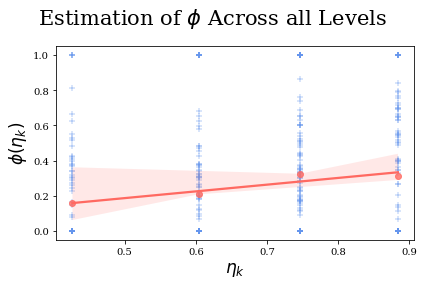

In [49]:
## [FIGURE 2 (b)] with method = "k_gmm"

# --- Also
## [FIGURE 12 (b)] with method = "buckets" and bucket_num = 3
## [FIGURE 13 (b)] with method = "buckets" and bucket_num = 5
## [FIGURE 14 (b)] with method = "buckets" and bucket_num = 7
## [FIGURE 15 (b)] with method = "buckets" and bucket_num = 10
## [FIGURE 15 (b)] with method = "q_buckets" and bucket_num = 10
## [FIGURE 24 (b)] with method = "k_gmm" and focus_on = "B1"

new_d = d_weights_total.groupby('pj').agg({'Weight': 'mean'}).reset_index() 
new_d.Weight = new_d.Weight.divide(sum(new_d.Weight))
sns.scatterplot(x='pj', y='Weight', data=d_weights_total, color=mediumblue, marker='+') 
sns.regplot(x='pj', y='Weight', data=new_d, scatter=True, color=red) 
plt.suptitle('Estimation of $\phi$ Across all Levels', fontsize=fontsize_title) 
plt.xlabel("$\eta_{k}$", fontsize = fontsize_axis)
plt.ylabel("$\phi(\eta_{k})$", fontsize = fontsize_axis) 
plt.tight_layout()
print(sum(new_d.Weight))

if focus_on == 'B1': 
    plt.savefig('../figures/Figure24b.pdf')
else: 
    plt.savefig('../figures/Figure2b.pdf')

In [50]:
if focus_on == 'B1': 
    d_weights_total.to_csv('../data/phi_w_batch1_k.csv')
else: 
    d_weights_total.to_csv('../data/phi_w_gmm.csv')

## Compute q

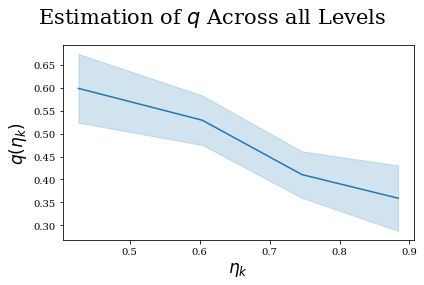

In [51]:
## (EXPLORATORY) PLOT Q

sns.lineplot(data=merged_df, x="Labels_GMM", y="ProbaDel", err_style="band", errorbar=("se", 2),)
plt.suptitle('Estimation of $q$ Across all Levels', fontsize=fontsize_title) 
plt.xlabel("$\eta_{k}$", fontsize = fontsize_axis) 
plt.ylabel("$q(\eta_{k})$", fontsize = fontsize_axis)
plt.tight_layout()

# Liquid v. Direct

- This section compares the performance of liquid and direct democracy

In [52]:
merged_df_flat['LDest'] = merged_df_flat.Answer*merged_df_flat.Weight
newdd = merged_df_flat[[
         'ID',
         'DelID',
         'GuruID',
         'Answer',
         'AverageExpertise',
         'Weight',
         'Confidence',
         'AvergeConfidence',
         'CodeQuestion',
         'CodeExclu',
         'ExpNum',
         'gender',
         'unique_id', 'IRTExpertise', 'Normalized_IRT','Normalized_IRT_1']] 

newdd['Cat'] = [0 for k in range (len(newdd))]
newld = merged_df_flat[[
         'ID',
         'DelID',
         'GuruID',
         'LDest',
         'AverageExpertise',
         'Weight',
         'Confidence',
         'AvergeConfidence',
         'CodeQuestion',
         'CodeExclu',
         'ExpNum',
         'gender',
         'unique_id', 'IRTExpertise', 'Normalized_IRT','Normalized_IRT_1']] 
newld['Cat'] = [1 for k in range (len(newld))]
newdd = newdd.rename(columns={'Answer':'Estimate'}) 
newld = newld.rename(columns={'LDest':'Estimate'}) 
df_flat = pd.concat([newdd, newld], sort=False) 

/Users/Manon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Manon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
codes_agg1 = []
codes_agg2 = []
codes_agg3 = []
dd_agg, fd_agg = [], []
s_dd_agg, s_fd_agg = [], []
for name, group in exp_filter.groupby('ExpNum'):
    for name1, group1 in group.groupby('CodeQuestion'):
        dd = np.mean(group1.Answer)
        fd = np.mean(group1.Answer*group1.Weight)
        sdd = np.var(group1.Answer)
        sfd = np.var(group1.Answer*group1.Weight)
        c1, c2, c3 = name, name1, list(group1.CodeExclu)[0]
        dd_agg.append(dd)
        fd_agg.append(fd)
        s_dd_agg.append(dd)
        s_fd_agg.append(fd)
        codes_agg1.append(c1)
        codes_agg2.append(c2)
        codes_agg3.append(c3)

newdd = pd.DataFrame(list(zip(codes_agg1, codes_agg2, codes_agg3, dd_agg)), columns=['ExpNum', 'CodeQuestion', 'CodeExclu', 'DD'])
newfd = pd.DataFrame(list(zip(codes_agg1, codes_agg2, codes_agg3, fd_agg)), columns=['ExpNum', 'CodeQuestion', 'CodeEx clu', 'LD'])
newdd['Cat'] = [0 for k in range (len(newdd))]
newfd['Cat'] = [1 for k in range (len(newfd))]
newdd = newdd.rename(columns={'DD':'Estimate'}) 
newfd = newfd.rename(columns={'LD':'Estimate'}) 

if focus_on == 'B1':
    pd.concat([newdd, newfd], sort=False).to_csv('../data/LDvDD_batch1.csv') 
else:
    pd.concat([newdd, newfd], sort=False).to_csv('../data/LDvDD.csv')

In [54]:
codes_agg1 = []
codes_agg2 = []
codes_agg3 = []
dd_agg, fd_agg = [], []
s_dd_agg, s_fd_agg = [], []
for name, group in merged_df.groupby('ExpNum'):
    for name1, group1 in merged_df.groupby('CodeExclu'):
        dd = np.mean(group1.Normalized_IRT)
        fd = np.mean(group1.Normalized_IRT*group1.Weight)
        sdd = np.var(group1.Normalized_IRT)
        sfd = np.var(group1.Normalized_IRT*group1.Weight)
        c1, c2 = name, name1
        dd_agg.append(dd)
        fd_agg.append(fd)
        s_dd_agg.append(dd)
        s_fd_agg.append(fd)
        codes_agg1.append(c1)
        codes_agg2.append(c2)

newdd = pd.DataFrame(list(zip(codes_agg1, codes_agg2, dd_agg)), columns=['ExpNum', 'CodeExclu', 'DD'])
newfd = pd.DataFrame(list(zip(codes_agg1, codes_agg2, fd_agg)), columns=['ExpNum', 'CodeExclu', 'LD']) 
newdd['Cat'] = [0 for k in range (len(newdd))]
newfd['Cat'] = [1 for k in range (len(newfd))]
newdd = newdd.rename(columns={'DD':'Estimate'})
newfd = newfd.rename(columns={'LD':'Estimate'}) 

if focus_on == 'B1':
    pd.concat([newdd, newfd], sort=False).to_csv('../data/LDvDD_means_batch1.csv') 
else:
    pd.concat([newdd, newfd], sort=False).to_csv('../data/LDvDD_means.csv')

('E10', 'PC2')
w
('E10', 'T1')
('E11', 'PC5')
w
('E11', 'PE94')
w
('E11', 'PE97')
('E11', 'S1')
w
('E11', 'T8')
('E12', 'PC6')
('E12', 'PE125')
w
('E12', 'PE127')
('E12', 'T7')
w
('E12', 'T8')
w
('E13', 'K3')
('E13', 'KKK4')
w
('E13', 'KKKK1')
('E13', 'KKKK2')
w
('E13', 'KKKK4')
w
('E13', 'KKKK7')
w
('E13', 'PE132')
w
('E13', 'PE133')
('E13', 'PE134')
w
('E13', 'PPE138')
('E13', 'PPPE131')
w
('E13', 'PPPE135')
w
('E13', 'PPPE138')
('E13', 'T7')
w
('E13', 'TTT4')
w
('E13', 'TTT6')
('E8', 'PC6')
('E8', 'PE87')
w
('E8', 'PE88')
w
('E8', 'T1')
w
('E8', 'T6')
w
('E9', 'PE92')
('E9', 'PE95')
('E9', 'PE96')
w
('E9', 'T1')


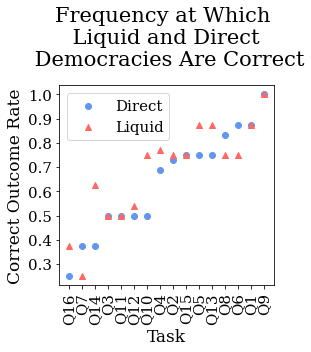

In [55]:
## [Figure 17]

# Calculate the average for 'Direct' and 'Liquid' by 'CodeExclu'
both, none, direct, liquid = 0, 0, 0, 0
exp, code, codee, est, outcome_d, outcome_l = [], [], [], [], [], []
for i, r in merged_df_flat.groupby(['ExpNum', 'CodeQuestion']):
    qboth, qnone, qdirect, qliquid = 0, 0, 0, 0
    exp.append(i[0])
    code.append(i[1])
    codee.append(list(r.CodeExclu)[0])
    if sum([np.mean(r.Answer)>0.5, np.mean(r.Answer*r.Weight)>0.5]) == 2:
        both += 1
        qboth += 1
        outcome_d.append(1)
        outcome_l.append(1)
        est.append(1)
        est.append(0)
    if sum([np.mean(r.Answer)>0.5, np.mean(r.Answer*r.Weight)>0.5]) == 0:
        none += 1
        qnone += 1
        outcome_d.append(0)
        outcome_l.append(0)
        est.append(1)
        est.append(0)
    if sum([np.mean(r.Answer)>0.5, np.mean(r.Answer*r.Weight)>0.5]) == 1:
        if np.mean(r.Answer)>0.5:
            direct += 1
            print(i)
            outcome_l.append(0)
            outcome_d.append(1)
            est.append(1)
            est.append(0)
        else:
            liquid +=1 
            print('w')
            print(i)
            outcome_l.append(1)
            outcome_d.append(0)
            est.append(1)
            est.append(0)

correct = pd.DataFrame({'ExpNum':exp, 'CodeQuestion':code, 'CodeExclu': codee, 'Direct':outcome_d, 'Liquid':outcome_l})
grouped_data = correct.groupby('CodeExclu').mean().sort_values('Direct') 
grouped_data = grouped_data.reset_index() 
plt.figure(figsize=(4,5))
plt.scatter(x=grouped_data['CodeExclu'].map(dict_labels), y=grouped_data['Direct'], marker='o', label='Direct', color = mediumblue)
plt.scatter(x=grouped_data['CodeExclu'].map(dict_labels), y=grouped_data['Liquid'], marker='^', label='Liquid', color = red)

plt.xlabel('Task', fontsize=fontsize_axis)
plt.ylabel('Correct Outcome Rate', fontsize=fontsize_axis)
plt.title('Frequency at Which \n Liquid and Direct \n Democracies Are Correct', fontsize=fontsize_title, pad=20) 
plt.legend()
plt.grid(False)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.tick_params(which='minor', bottom=False)
plt.legend(fontsize=15, loc='upper left')
plt.tight_layout()

if focus_on == 'B1': 
    plt.savefig('correct_batch1.pdf',bbox_inches='tight')
else: 
    plt.savefig('../figures/Figure17.pdf',bbox_inches='tight')

# Plot Delegation Graphs

In [56]:
import networkx as nx

/Users/Manon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


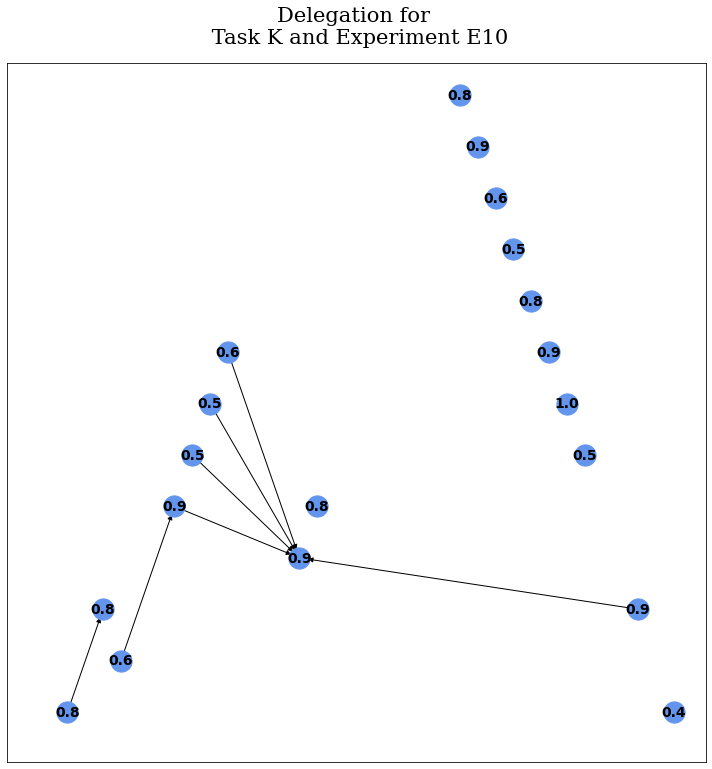

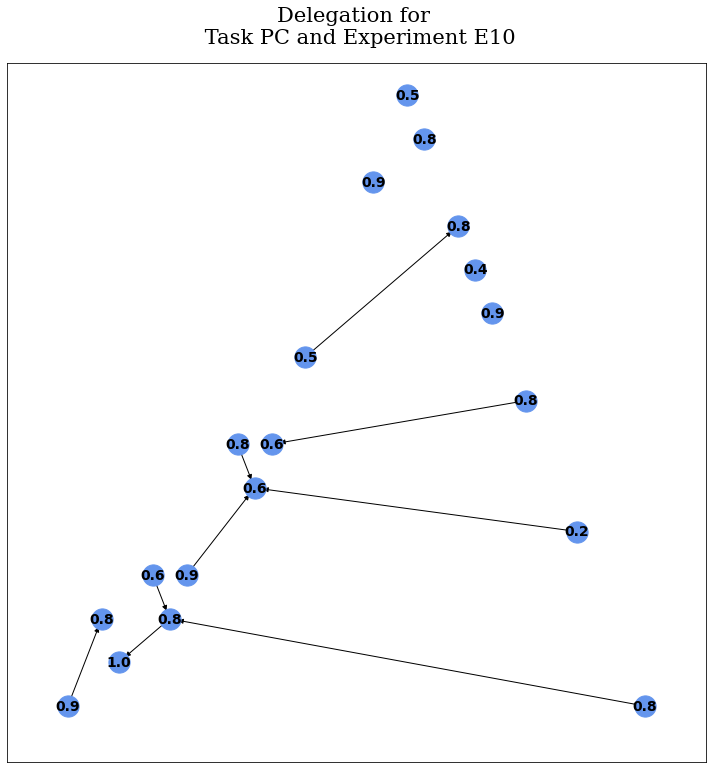

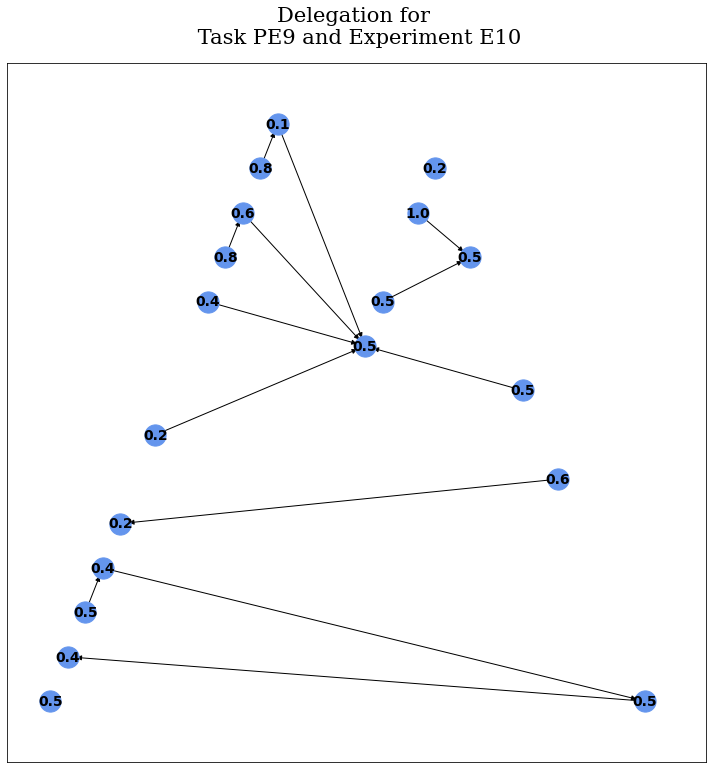

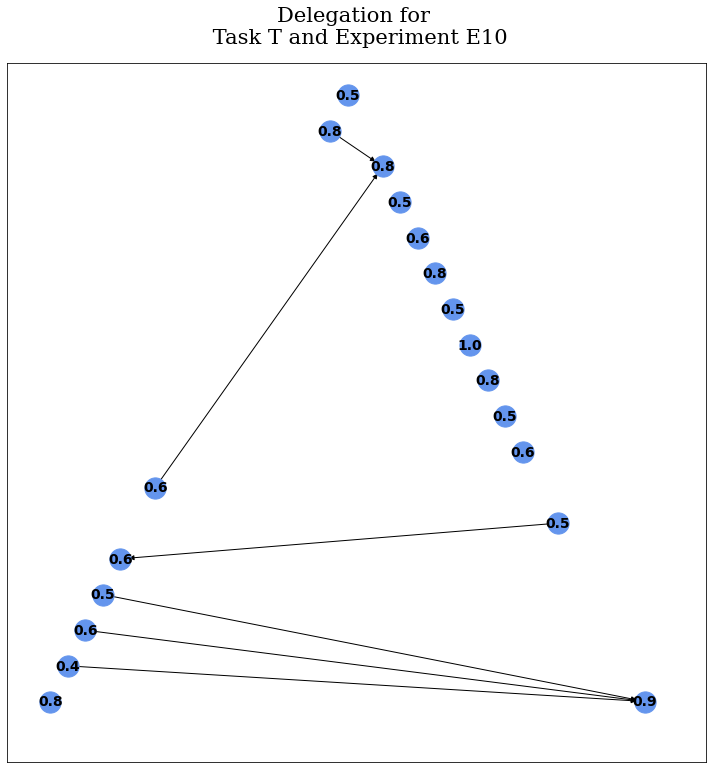

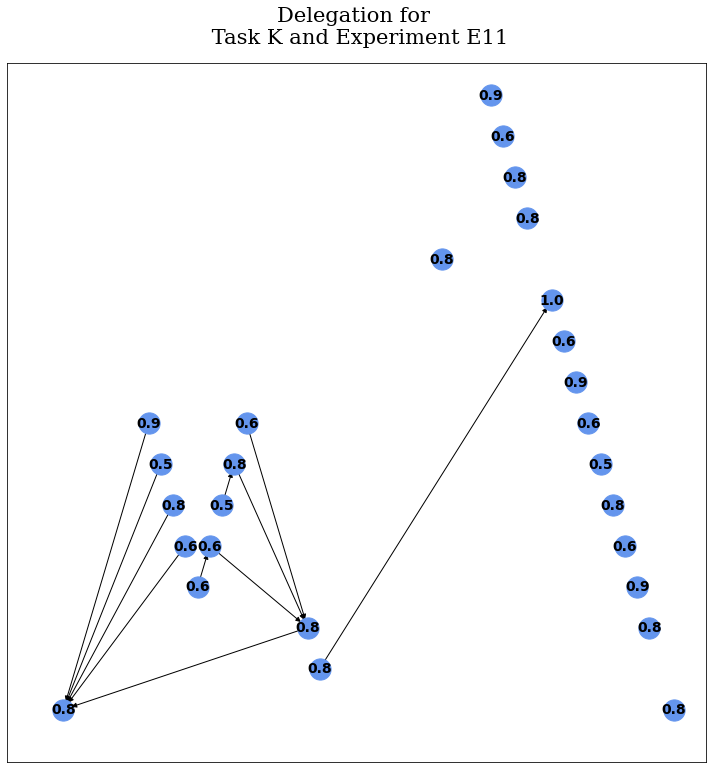

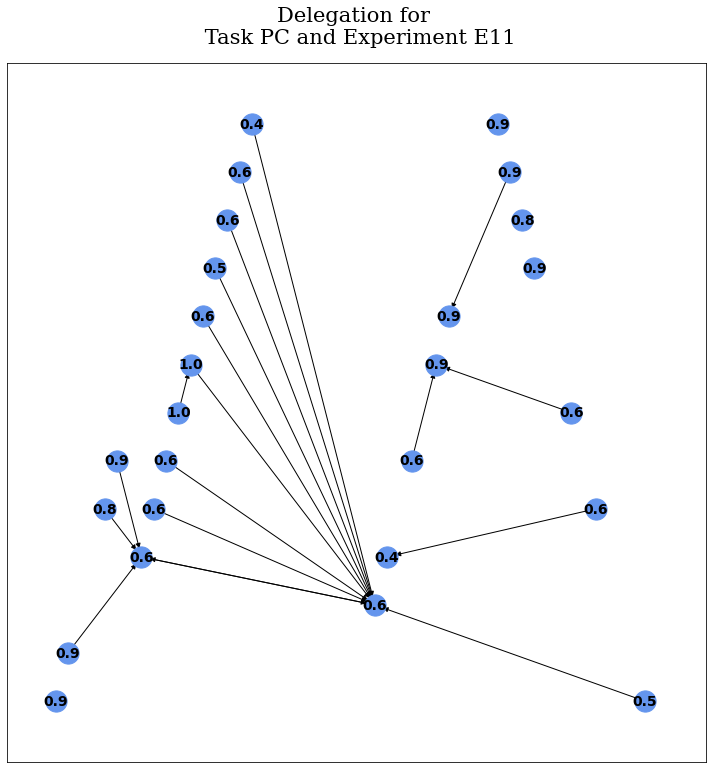

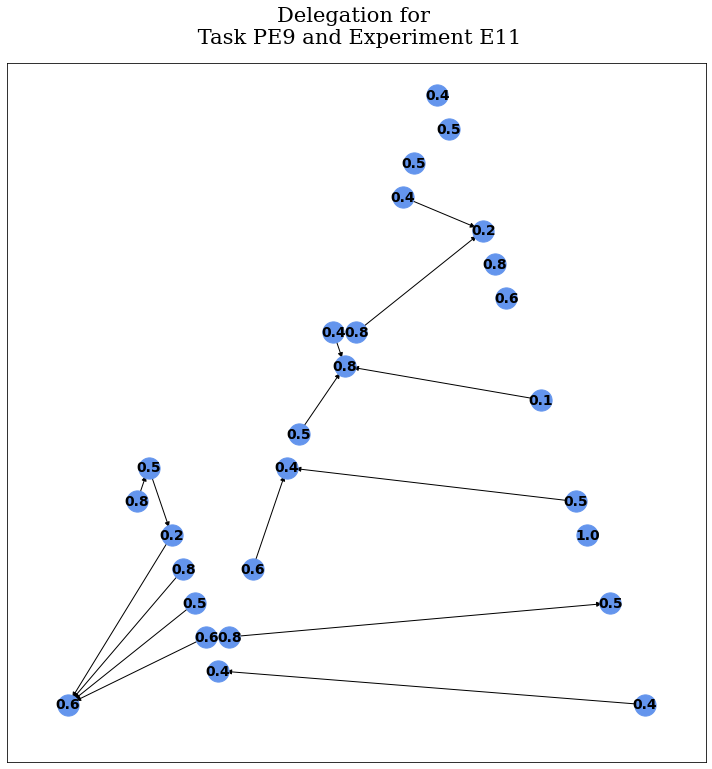

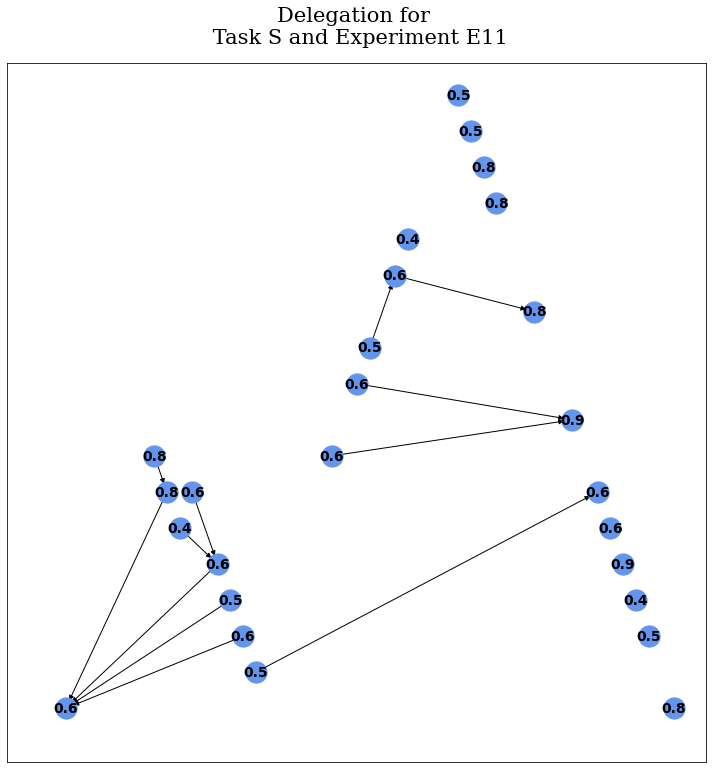

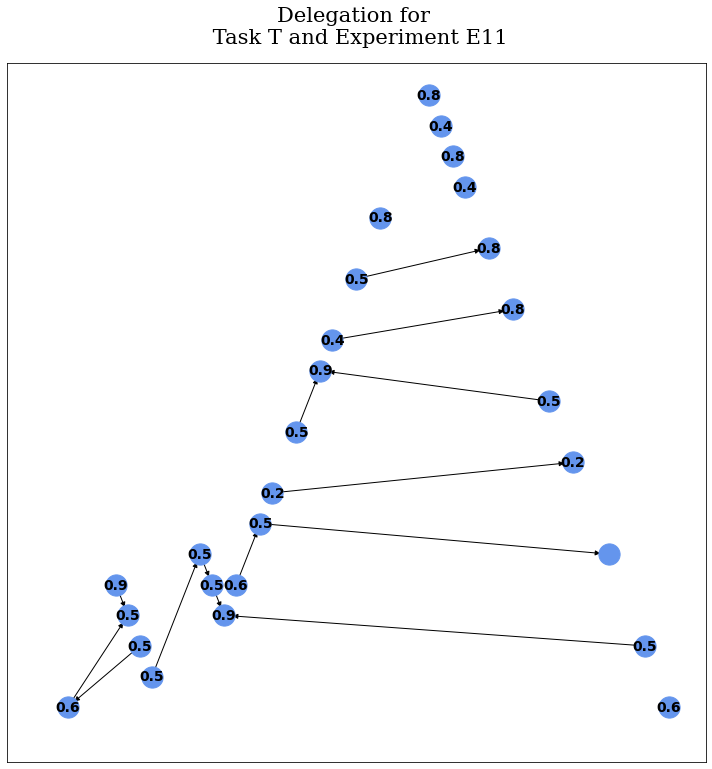

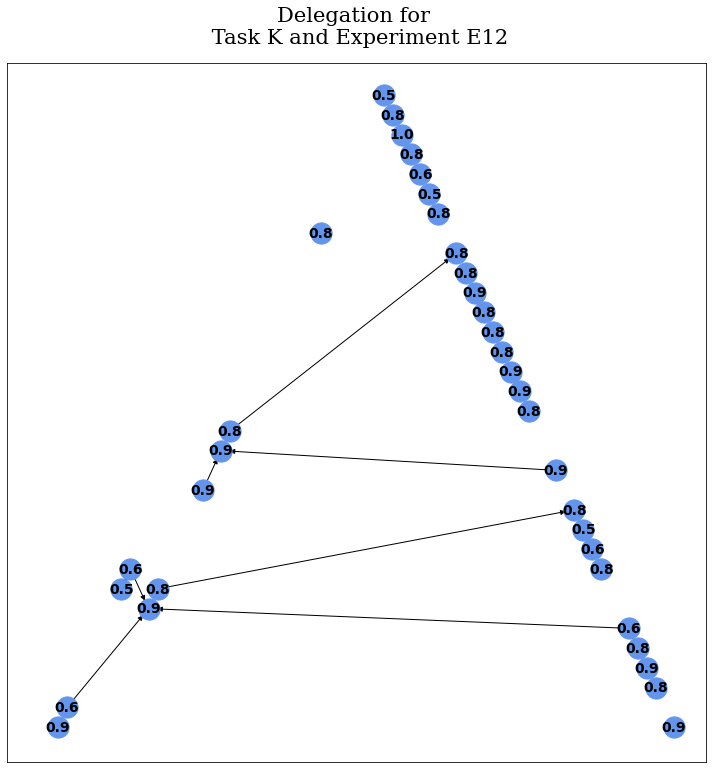

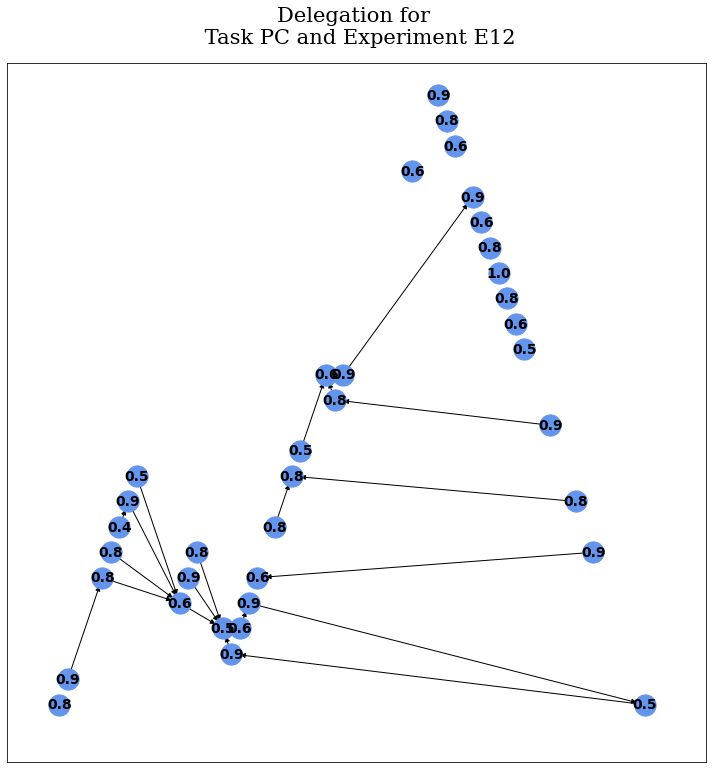

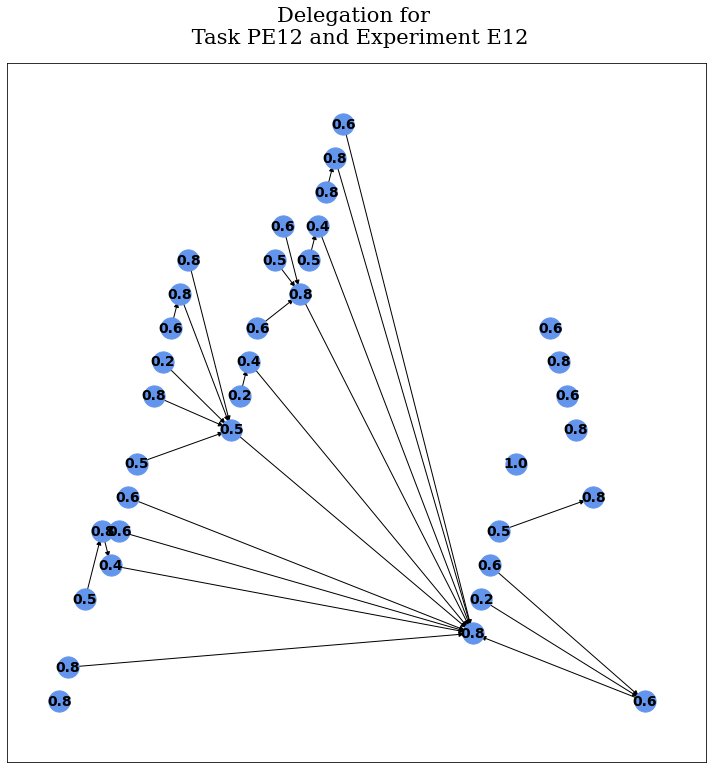

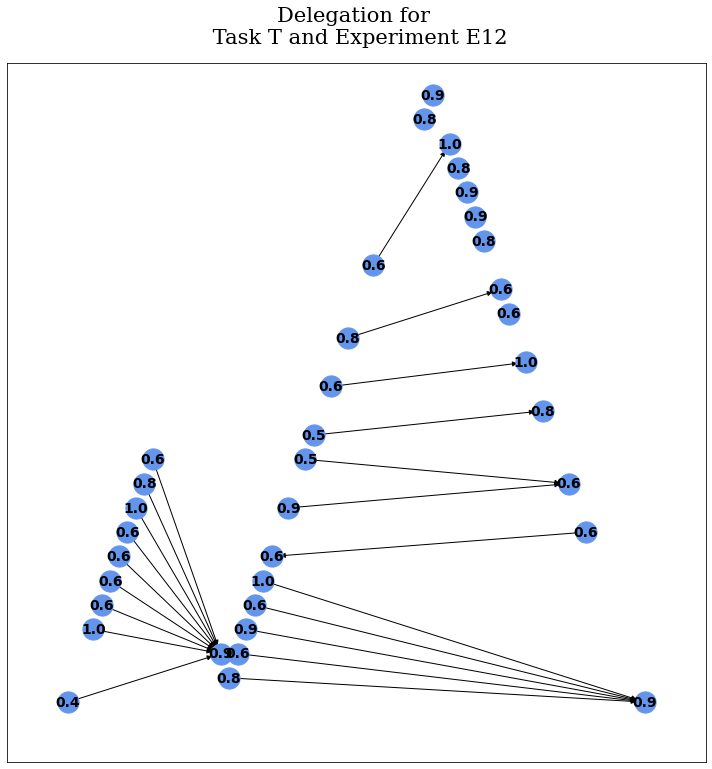

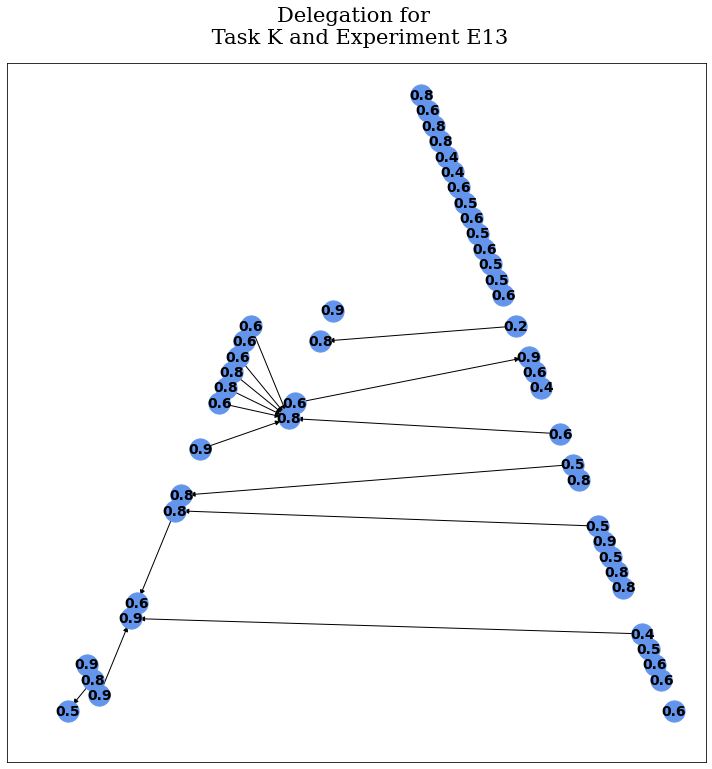

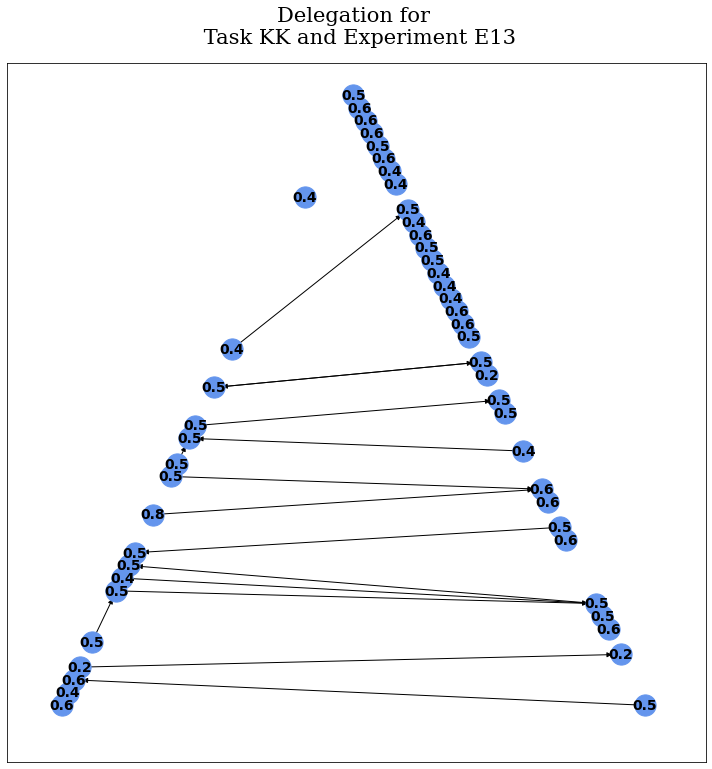

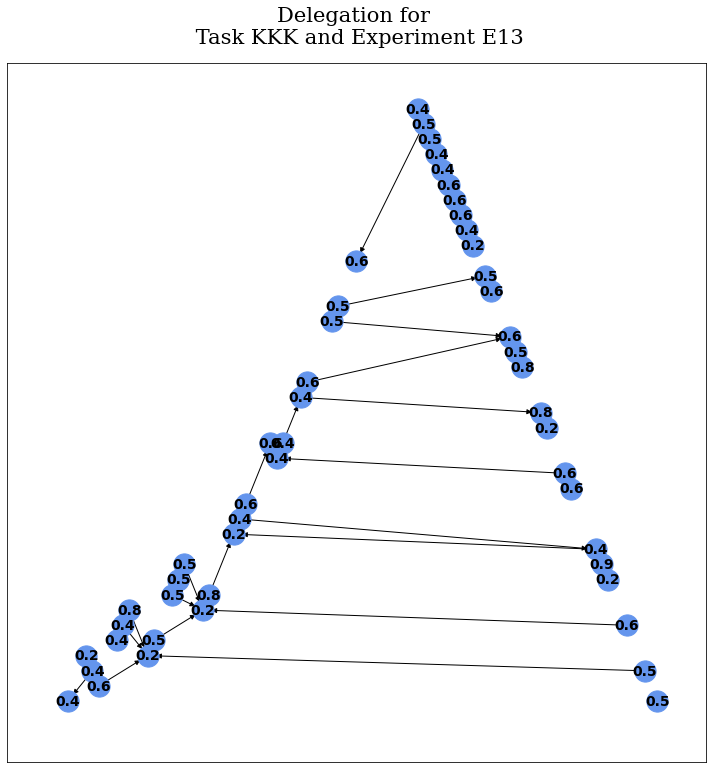

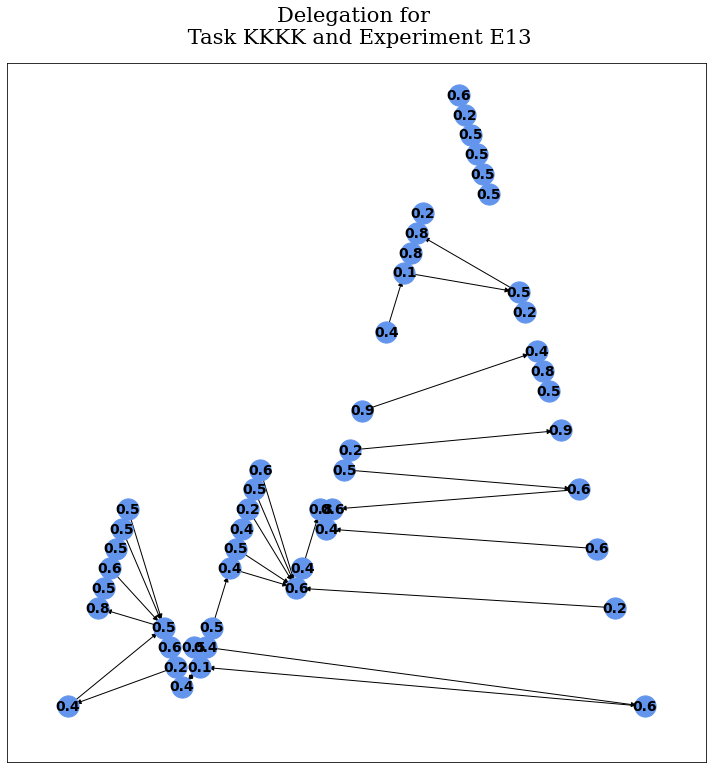

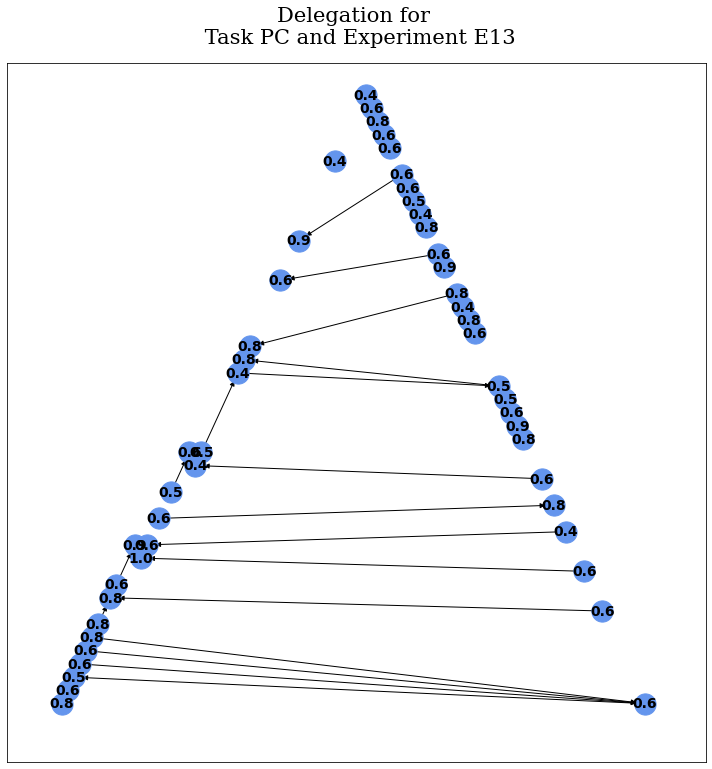

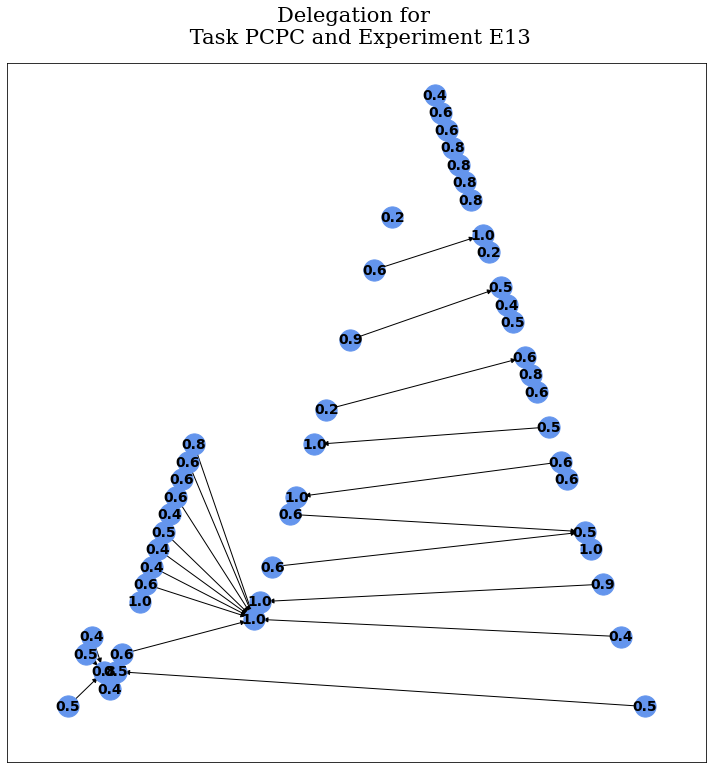

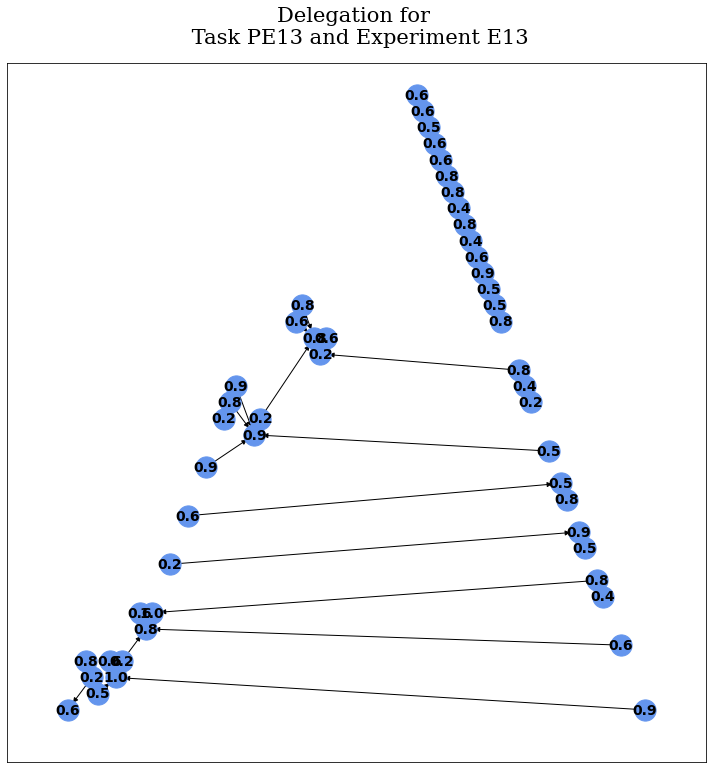

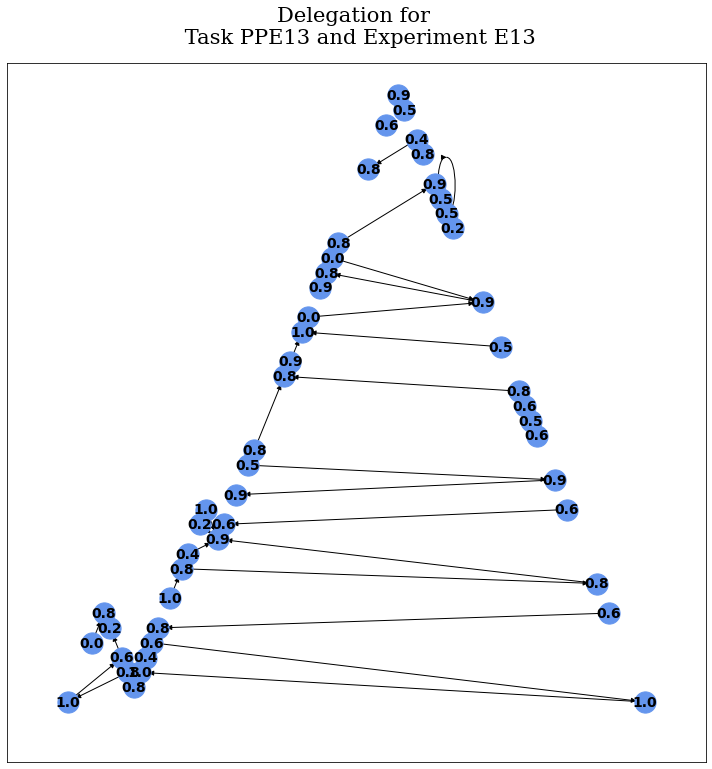

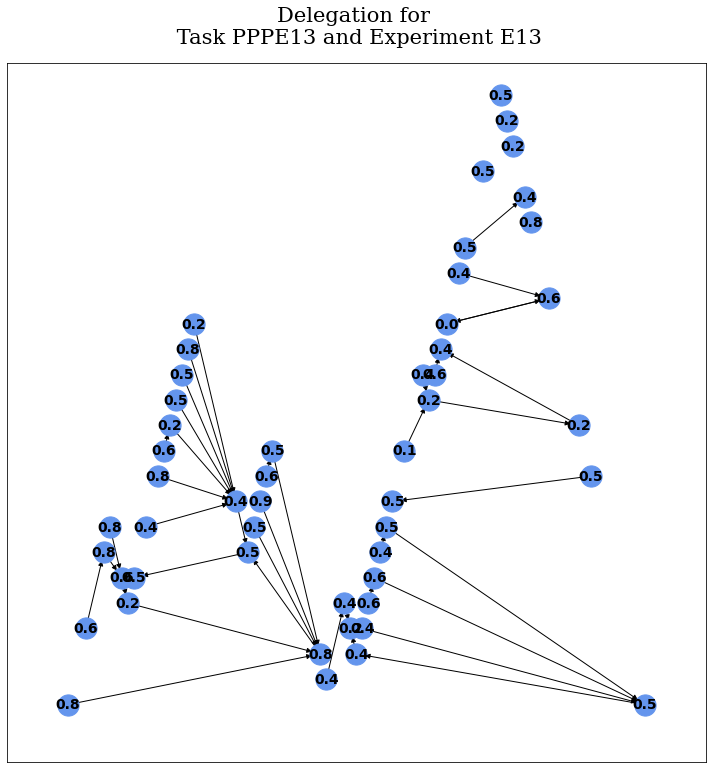

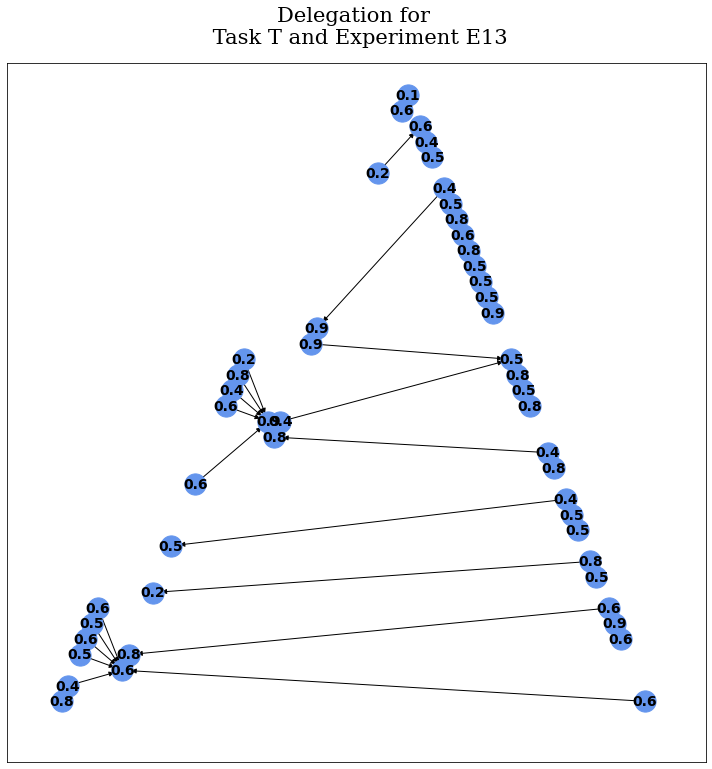

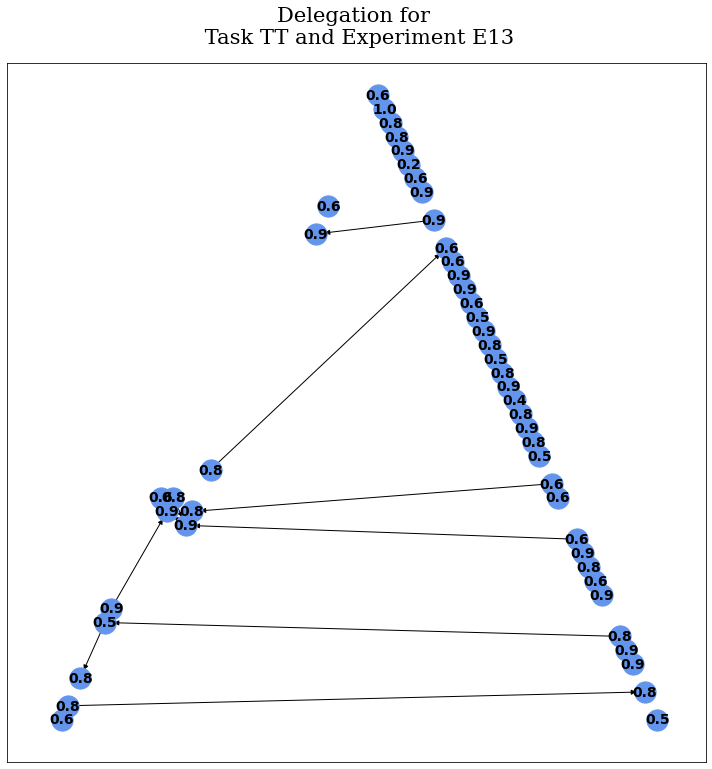

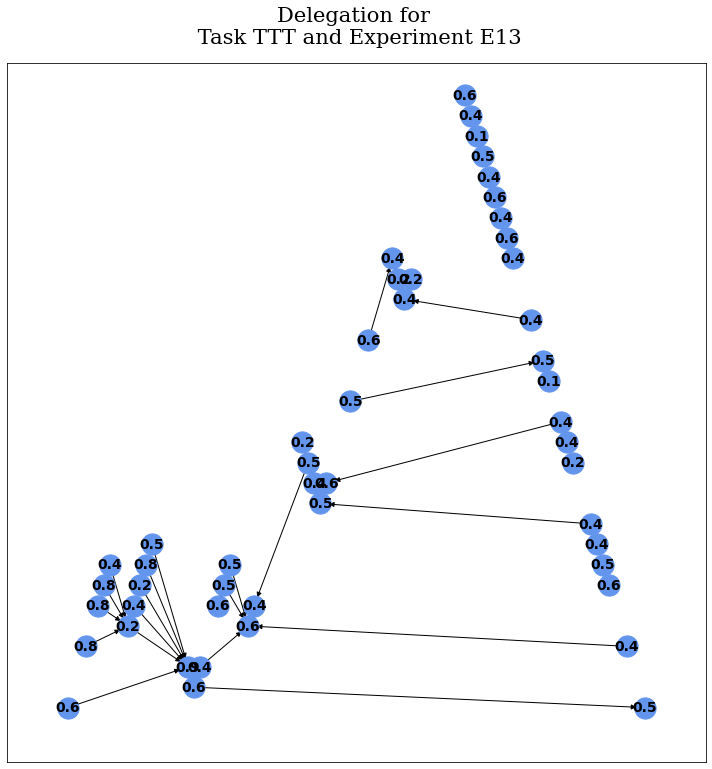

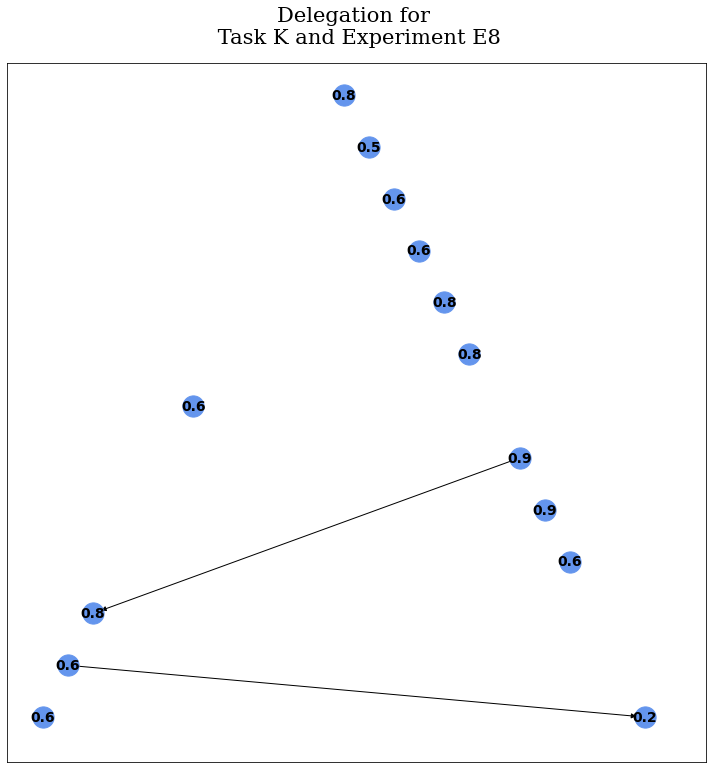

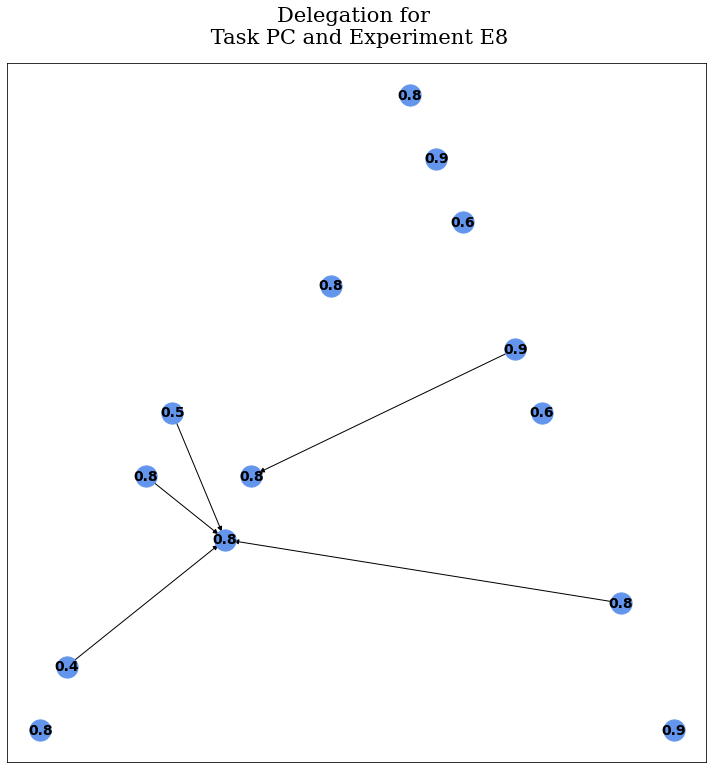

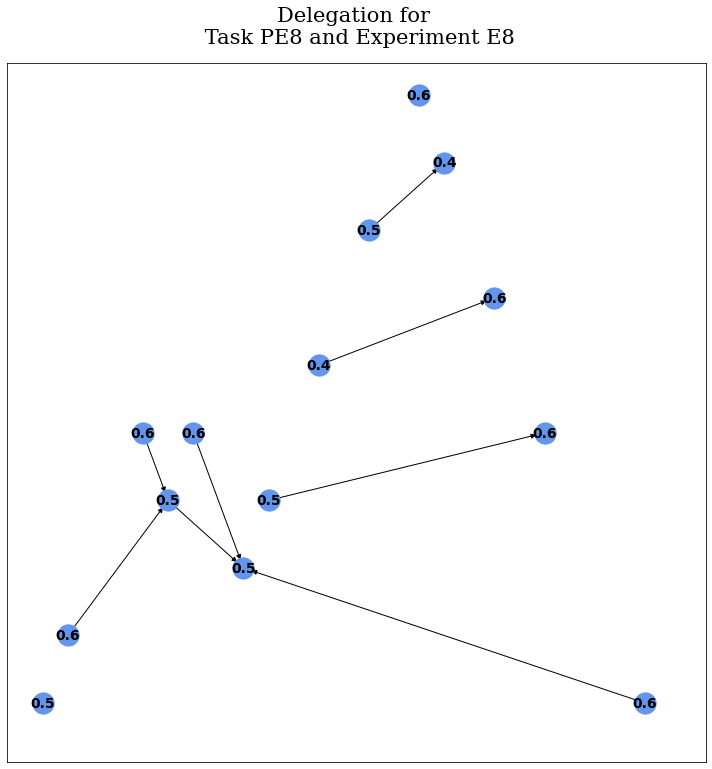

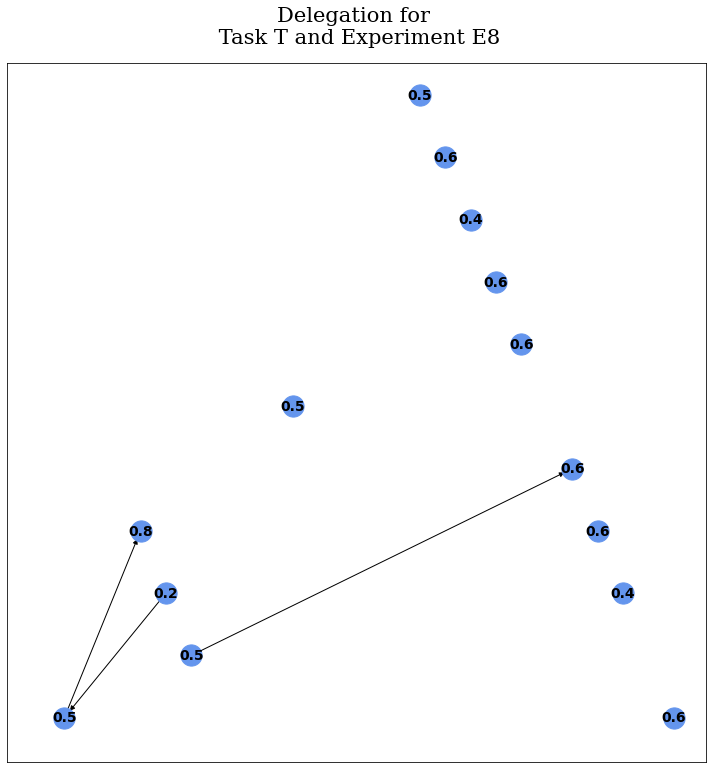

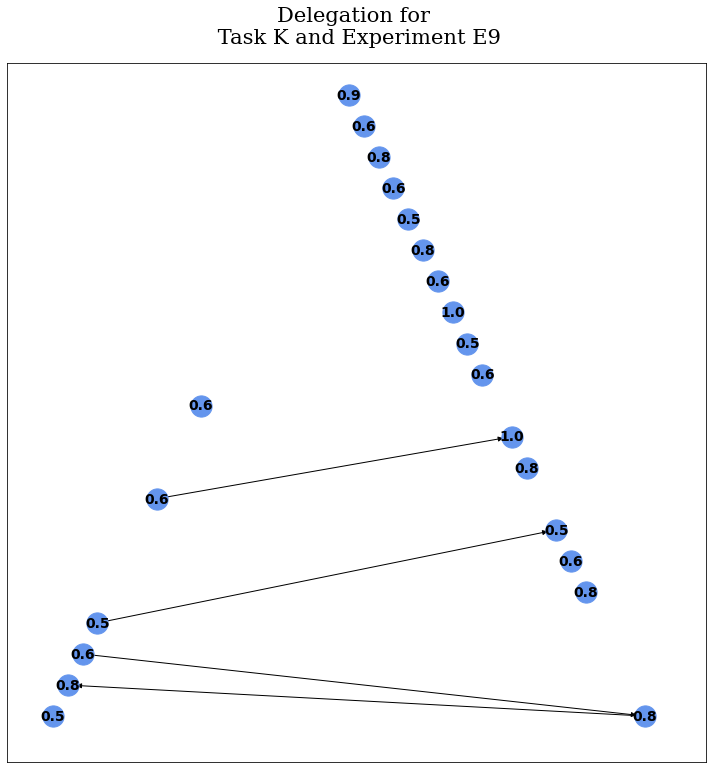

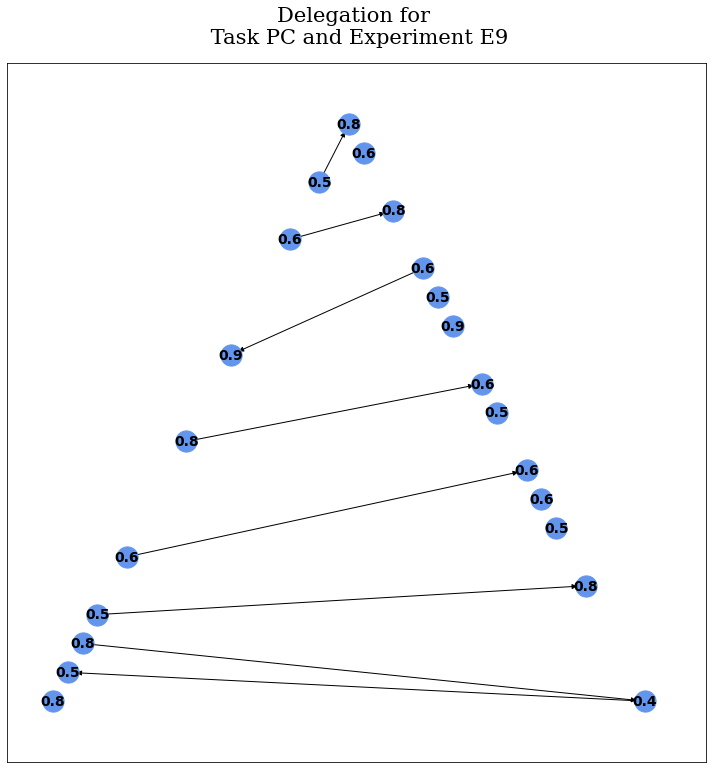

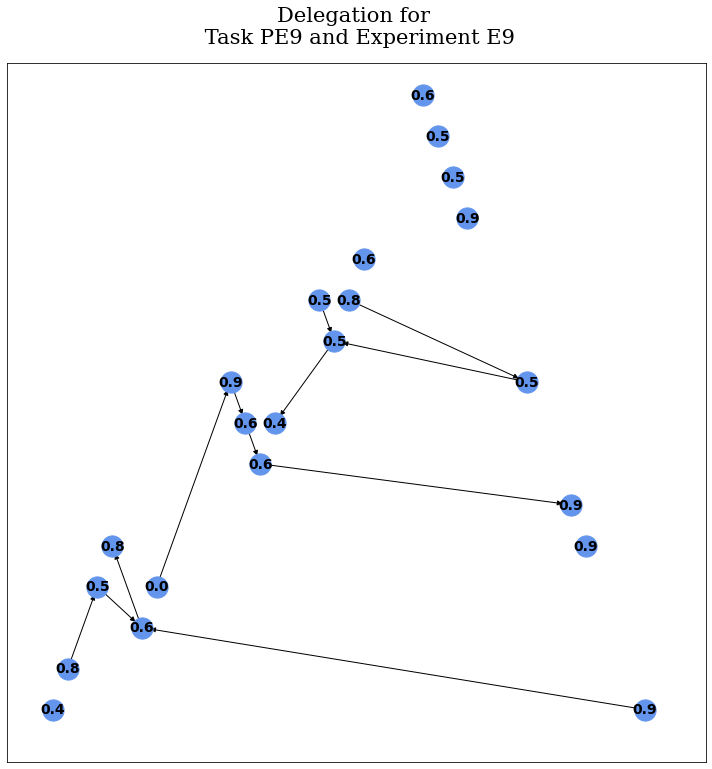

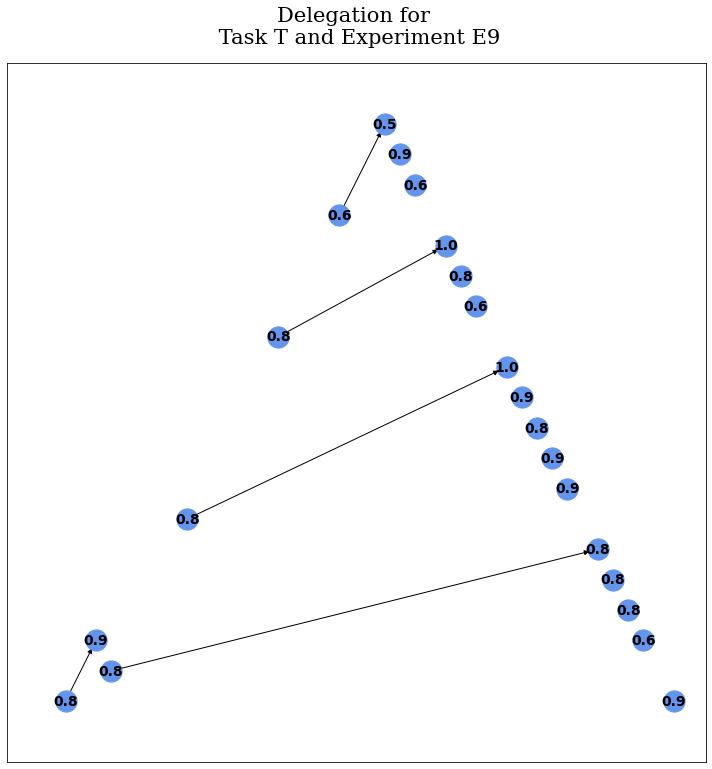

In [57]:
for j, group in behavior.groupby(['ExpNum', 'CodeExclu']):
    G=nx.DiGraph()
    for i in group['ID']:
        G.add_node(i)
    for i, row in group.iterrows():
        if str(row['DelID']) != 'nan':
            G.add_edge(row['ID'], row['DelID'])

    label = {} 
    for i, r in group.iterrows():
        if r['ID'] in G.nodes():
            label[r['ID']] = round(r['AverageExpertise'], 1)

    fig = plt.figure(figsize=(10, 10))
    pos = nx.planar_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color = 'cornflowerblue', node_size=450)
    nx.draw_networkx_labels(G, pos, label, font_size=14, font_color="black", font_weight="bold")
    nx.draw_networkx_edges(G, pos, arrows=True)
    plt.tight_layout()
    plt.title(f'Delegation for \n Task {j[1]} and Experiment {j[0]}', fontsize=21, pad=20)
    plt.tick_params(which='minor', bottom=False)
    plt.savefig(f'../figures/delegation_graph{j[0]}_{j[1]}.pdf',bbox_inches='tight')
